In [65]:
import numpy as np  
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from scipy.stats import entropy, chi2_contingency, norm, ttest_1samp
import scipy.spatial.distance as distance
import statsmodels.stats.multitest as multitest
from folktables import ACSDataSource
import statsmodels.api as sm


In [75]:
#Create sample hiring data

def hiring_data(shift, n=10000,d=0.09):
    
    np.random.seed(36)
    
    U = np.random.normal(0, 1, n)
    X = np.random.binomial(1,np.exp(U)/(1+(np.exp(U))),n)
    Z = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
    W = np.random.binomial(1,0.3*(X+Z) + 0.1,n)
    Y = np.random.binomial(1,(1/5)*(X+Z)+(1/4)*W+0.02,n)
    sample_1 = pd.DataFrame({'X':X, 'Z':Z, 'W':W, 'Y':Y})

    if shift == 1:
        U = np.random.normal(0, 1, n)
        X = np.random.binomial(1,np.exp(U)/(1+(np.exp(U))),n)
        Z = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
        W = np.random.binomial(1,0.3*(X+Z) + 0.1,n)
        Y = np.random.binomial(1,(1/5)*(X+Z)+(1/4)*W+0.02+d,n)
        sample_2 = pd.DataFrame({'X':X, 'Z':Z, 'W':W, 'Y':Y})
    
    elif shift == 2:
        U = np.random.normal(0, 1, n)
        X = np.random.binomial(1,np.exp(U)/(1+(np.exp(U+0.5))),n)
        Z = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
        W = np.random.binomial(1,0.3*(X+Z) + 0.1,n)
        Y = np.random.binomial(1,(1/5)*(X+Z)+(1/4)*W+0.02,n)
        sample_2 = pd.DataFrame({'X':X, 'Z':Z, 'W':W, 'Y':Y})

    elif shift == 3:
        U = np.random.normal(0, 1, n)
        X = np.random.binomial(1,np.exp(U)/(1+(np.exp(U))),n)
        Z = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
        W = np.random.binomial(1,0.3*(X+Z) + 0.1,n)
        Y = np.random.binomial(1,0.3*X+(1/5)*Z+(1/4)*W+0.02,n)
        sample_2 = pd.DataFrame({'X':X, 'Z':Z, 'W':W, 'Y':Y})
    else:       
        U = np.random.normal(0, 1, n)
        X = np.random.binomial(1,np.exp(U)/(1+(np.exp(U))),n)
        Z = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
        W = np.random.binomial(1,0.3*(X+Z) + 0.1,n)
        Y = np.random.binomial(1,(1/5)*(X+Z)+(1/4)*W+0.02,n)

        sample_2 = pd.DataFrame({'X':X, 'Z':Z, 'W':W, 'Y':Y})
    
    return sample_1, sample_2

sample_1, sample_2 = hiring_data(0)
_, sample_3 = hiring_data(1)
_, sample_4 = hiring_data(3)


#Save Sample 1 and Sample 4 to CSV
sample_1.to_csv('sample_1.csv')
sample_4.to_csv('sample_4.csv')

In [67]:
sample_1[sample_1['X']==0]['Z'].mean()

0.4327038971474488

In [68]:
x_de = 0
x_ie = 0
x_se = 0
changed_factor_de = 0
changed_factor_ie = 0

for z in [0,1]:
    p_z_x0 = sample_1[(sample_1['Z']==z) & (sample_1['X']==0)].shape[0]/sample_1[sample_1['X']==0].shape[0]
    p_z_x1 = sample_1[(sample_1['Z']==z) & (sample_1['X']==1)].shape[0]/sample_1[sample_1['X']==1].shape[0]
    for w in [0,1]:
        p_w_z_x0 = sample_1[(sample_1['W']==w) & (sample_1['Z']==z) & (sample_1['X']==0)].shape[0]/sample_1[(sample_1['Z']==z) & (sample_1['X']==0)].shape[0]
        p_w_z_x1 = sample_1[(sample_1['W']==w) & (sample_1['Z']==z) & (sample_1['X']==1)].shape[0]/sample_1[(sample_1['Z']==z) & (sample_1['X']==1)].shape[0]

        p_y_w_z_x0 = sample_1[(sample_1['Y']==1) & (sample_1['W']==w) & (sample_1['Z']==z) & (sample_1['X']==0)].shape[0]/sample_1[(sample_1['W']==w) & (sample_1['Z']==z) & (sample_1['X']==0)].shape[0]
        p_y_w_z_x1 = sample_1[(sample_1['Y']==1) & (sample_1['W']==w) & (sample_1['Z']==z) & (sample_1['X']==1)].shape[0]/sample_1[(sample_1['W']==w) & (sample_1['Z']==z) & (sample_1['X']==1)].shape[0]

        x_de += (p_y_w_z_x1-p_y_w_z_x0)*p_w_z_x0*p_z_x0
        x_ie += p_y_w_z_x1*(p_w_z_x0-p_w_z_x1)*p_z_x0
        x_se += p_y_w_z_x1*p_w_z_x1*(p_z_x0-p_z_x1)
        changed_factor_de += p_w_z_x0*p_z_x0
        changed_factor_ie += (p_w_z_x0-p_w_z_x1)*p_z_x0


print(x_de)
print(x_ie)
print(x_se)
print(changed_factor_de)
print(np.round(changed_factor_ie))
        

#Repeat for sample 2
x_de = 0
x_ie = 0
x_se = 0
changed_factor_de = 0
changed_factor_ie = 0

for z in [0,1]:
    p_z_x0 = sample_2[(sample_2['Z']==z) & (sample_2['X']==0)].shape[0]/sample_2[sample_2['X']==0].shape[0]
    p_z_x1 = sample_2[(sample_2['Z']==z) & (sample_2['X']==1)].shape[0]/sample_2[sample_2['X']==1].shape[0]
    for w in [0,1]:
        p_w_z_x0 = sample_2[(sample_2['W']==w) & (sample_2['Z']==z) & (sample_2['X']==0)].shape[0]/sample_2[(sample_2['Z']==z) & (sample_2['X']==0)].shape[0]
        p_w_z_x1 = sample_2[(sample_2['W']==w) & (sample_2['Z']==z) & (sample_2['X']==1)].shape[0]/sample_2[(sample_2['Z']==z) & (sample_2['X']==1)].shape[0]

        p_y_w_z_x0 = sample_2[(sample_2['Y']==1) & (sample_2['W']==w) & (sample_2['Z']==z) & (sample_2['X']==0)].shape[0]/sample_2[(sample_2['W']==w) & (sample_2['Z']==z) & (sample_2['X']==0)].shape[0]
        p_y_w_z_x1 = sample_2[(sample_2['Y']==1) & (sample_2['W']==w) & (sample_2['Z']==z) & (sample_2['X']==1)].shape[0]/sample_2[(sample_2['W']==w) & (sample_2['Z']==z) & (sample_2['X']==1)].shape[0]

        x_de += (p_y_w_z_x1-p_y_w_z_x0)*p_w_z_x0*p_z_x0
        x_ie += p_y_w_z_x1*(p_w_z_x0-p_w_z_x1)*p_z_x0
        x_se += p_y_w_z_x1*p_w_z_x1*(p_z_x0-p_z_x1)
        changed_factor_de += p_w_z_x0*p_z_x0
        changed_factor_ie += (p_w_z_x0-p_w_z_x1)*p_z_x0


print(x_de)
print(x_ie)
print(x_se)
print(changed_factor_de)
print(np.round(changed_factor_ie))

                                     
                                    



0.2031824704455139
-0.0810494464587179
-0.03854073197425048
1.0
-0.0
0.19263199524590777
-0.06795163924643415
-0.045218686436029394
0.9999999999999998
0.0


In [69]:
def weighted_outcomes_bootstrap_test_schrouff(sample_a,sample_b, target, causal_parents_source, B=10000, split=0.75):

    '''
    Function to perform weighted bootstrap test for difference in conditional probabilities of Y=1 given X,Z,W for two samples
    as described in Schrouff et al. (2022)

    Parameters:

    sample_a: pandas DataFrame containing sample A
    sample_b: pandas DataFrame containing sample B
    causal_parents_source: list of strings containing causal paraents of variable of interest (i.e. PA(Y) = {X,Z,W})
    B: int, number of bootstrap iterations
    split: float, proportion of samples to use for estimating the weights using logistic regression

    Returns:

    bootstrapped_t_stats: numpy array containing bootstrapped t-statistics for each tested conditional probability
    bootstrapped_mean_probabilities: numpy array containing the mean bootstrapped probabilities for each tested conditional probability
    bootstrapped_weights_mean: numpy array containing the mean bootstrapped weights for each sample
    bootstrapped_weighted_means: numpy array containing the bootstrapped weighted means for each sample
    bootstrapped_pooled_se: numpy array containing the bootstrapped pooled standard errors for each tested conditional probability
    p_values: float containing the p-value obtained from a two-sided z-test of the bootstrapped t-statistics distribution against 0
    '''



    #Step 1: Split initial samples into weighting and testing sets
    ##Split the samples
    sample_a_weights = sample_a.sample(frac=split)
    sample_b_weights = sample_b.sample(frac=split)
    sample_a_testing = sample_a[~sample_a.index.isin(sample_a_weights.index)]
    sample_b_testing = sample_b[~sample_b.index.isin(sample_b_weights.index)]
    ##initialize empty arrays to store bootstrapped t-statistics, bootstrapped probabilities, mean bootstrapped weights and bootstrapped weighted means
    bootstrapped_t_stats = np.empty(B)
    bootstrapped_mean_probabilities = np.empty(B)
    bootstrapped_weights_mean = np.empty((2,B))
    bootstrapped_weighted_outcome = np.empty((2,B))
    bootstrapped_pooled_se = np.empty(B)

    #Step2: perform bootstrap
    for i in tqdm.tqdm(range(B), desc='Bootstrapping'):
        #Test, for each bootstrap iteration have a different set for weights and testing
        #Step 2.1: Sample with replacement from the weights and testing
        bootstrap_sample_a_weights = sample_a_weights.sample(n=len(sample_a_weights), replace=True)
        bootstrap_sample_b_weights = sample_b_weights.sample(n=len(sample_b_weights), replace=True)
        bootstrap_sample_a_testing = sample_a_testing.sample(n=len(sample_a_testing), replace=True)
        bootstrap_sample_b_testing = sample_b_testing.sample(n=len(sample_b_testing), replace=True)

        #check if causal parents source is not empty¨
        if len(causal_parents_source) != 0:
            #Step 2.2: Fit logistic regression model to estimate weights
            ##Pool the samples
            pooled_weights = pd.concat([bootstrap_sample_a_weights, bootstrap_sample_b_weights])
            ##Add sample indicator
            pooled_weights['Sample'] = ['Sample A']*len(bootstrap_sample_a_weights) + ['Sample B']*len(bootstrap_sample_b_weights)
            ##Feature matrix X with intercept
            X = sm.add_constant(pooled_weights[causal_parents_source])
            ##Target vector Y with sample 1 as reference
            Y = (pooled_weights['Sample'] == 'Sample B').astype(int)
            ##Fit logistic regression model
            logit_model = sm.Logit(Y, X).fit(disp=0)
            ##extract weights on testing set
            X_a = sm.add_constant(bootstrap_sample_a_testing[causal_parents_source])
            X_b = sm.add_constant(bootstrap_sample_b_testing[causal_parents_source])
            p_a = logit_model.predict(X_a)
            p_a = 1-p_a #need to compute 1-pa, because the logit model predicts the probability of being in class b
            p_b = logit_model.predict(X_b)
            #Store the mean probability for p_a
            bootstrapped_mean_probabilities[i] = np.mean(p_a)
            if np.any(p_a == 0) or np.any(p_b == 0):
                print('Warning: Zero values in p_a or p_b')
            if np.any(p_a < 1e-10) or np.any(p_b < 1e-10):  # Threshold can vary based on the scale of your data
                print('Warning: Near-zero values in p_a or p_b')
            #Compute the weights
            w_a = 1/p_a
            w_b = 1/p_b
            #Normalize the weights
            w_a_norm = w_a/np.sum(w_a)
            w_b_norm = w_b/np.sum(w_b)
            #Check for nans and infs
            if np.any(np.isnan(w_a)) or np.any(np.isnan(w_b)):
                print('Warning: NaN values in w_a or w_b')
            if np.any(np.isinf(w_a)) or np.any(np.isinf(w_b)):
                print('Warning: Inf values in w_a or w_b')
            #Check for very small values
            if np.any(w_a < 1e-10) or np.any(w_b < 1e-10):
                print('Warning: Near-zero values in w_a or w_b')
            
            #Compute hadamard product
            Y_a = bootstrap_sample_a_testing[target].values
            Y_b = bootstrap_sample_b_testing[target].values
            product_a = w_a_norm.values*Y_a
            product_b = w_b_norm.values*Y_b
            together = np.concatenate([product_a,-product_b])
            bootstrapped_t_stats[i] = ttest_1samp(together, 0)[0]
            #Compute and store weighted means
            bootstrapped_weighted_outcome[0,i] = np.sum(product_a)
            bootstrapped_weighted_outcome[1,i] = np.sum(product_b)
            #Compute and store mean weights
            bootstrapped_weights_mean[0,i] = np.mean(w_a)
            bootstrapped_weights_mean[1,i] = np.mean(w_b)
        
        #If causal parents source is empty, we do not need to estimate the weights, they are all equal to 1
        else:
            Y_a = bootstrap_sample_a_testing[target].values
            Y_b = bootstrap_sample_b_testing[target].values
            together = np.concatenate([Y_a,-Y_b])
            bootstrapped_t_stats[i] = ttest_1samp(together, 0)[0]
            #Compute and store weighted means
            bootstrapped_weighted_outcome[0,i] = np.mean(Y_a)
            bootstrapped_weighted_outcome[1,i] = np.mean(Y_b)
            #Compute and store mean weights
            bootstrapped_weights_mean[0,i] = 1
            bootstrapped_weights_mean[1,i] = 1
    

    #Step 3: Compute p-values
    mean = np.mean(bootstrapped_t_stats)
    std = np.std(bootstrapped_t_stats)
    p_value = (2*norm.cdf(-abs(mean/std)))

    return bootstrapped_t_stats, p_value,bootstrapped_weighted_outcome,bootstrapped_mean_probabilities, bootstrapped_weights_mean


#Perform the test for sample 1 vs sample 2 
##For variable X
target = 'X'
##parents are empty
causal_parents_source = []
##Perform the test
#t_stats_x_s1s2, p_value_x_s1s2,weighted_means_x_s1s2,_,_ = weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_2, target, causal_parents_source, B=10000, split=0.75) 
##For variable Z|x
target = 'Z'
##parents are X
causal_parents_source = ['X']
##Perform the test
#t_stats_z_s1s2, p_value_z_s1s2,weighted_means_z_s1s2,_,_ = weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_2, target, causal_parents_source, B=10000, split=0.75)
##For variable W|X,Z
target = 'W'
##parents are X,Z
causal_parents_source = ['X','Z']
##Perform the test
#t_stats_w_s1s2, p_value_w_s1s2,weighted_means_w_s1s2,_,_ = weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_2, target, causal_parents_source, B=10000, split=0.75)
##For variable Y|X,Z,W
target = 'Y'
##parents are X,Z,W
causal_parents_source = ['X','Z','W']
##Perform the test
#t_stats_y_s1s2, p_value_y_s1s2,weighted_means_y_s1s2,_,_ = weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_2, target, causal_parents_source, B=10000, split=0.75)

#Now sample sample 3 with d = 0.09
_, sample_3 = hiring_data(1)
#perform the same tests for sample 1 vs sample 3
##For variable X
target = 'X'
##parents are empty
causal_parents_source = []
##Perform the test
#t_stats_x_s1s3, p_value_x_s1s3,weighted_means_x_s1s3,_,_ = weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_3, target, causal_parents_source, B=10000, split=0.75)
##For variable Z|x
target = 'Z'
##parents are X
causal_parents_source = ['X']
##Perform the test
#t_stats_z_s1s3, p_value_z_s1s3,weighted_means_z_s1s3,_,_ = weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_3, target, causal_parents_source, B=10000, split=0.75)
##For variable W|X,Z
target = 'W'
##parents are X,Z
causal_parents_source = ['X','Z']
##Perform the test
#t_stats_w_s1s3, p_value_w_s1s3,weighted_means_w_s1s3,_,_ = weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_3, target, causal_parents_source, B=10000, split=0.75)
##For variable Y|X,Z,W
target = 'Y'
##parents are X,Z,W
causal_parents_source = ['X','Z','W']
##Perform the test
#t_stats_y_s1s3, p_value_y_s1s3,weighted_means_y_s1s3,_,_ = weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_3, target, causal_parents_source, B=10000, split=0.75)

#Now sample sample 4 with shift = 2 (demographic shift)
_, sample_4 = hiring_data(2)
#perform the same tests for sample 1 vs sample 4
##For variable X
target = 'X'
##parents are empty
causal_parents_source = []
##Perform the test
t_stats_x_s1s4, p_value_x_s1s4,weighted_means_x_s1s4,_,_ = weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_4, target, causal_parents_source, B=10000, split=0.75)
##For variable Z|x
target = 'Z'
##parents are X
causal_parents_source = ['X']
##Perform the test
t_stats_z_s1s4, p_value_z_s1s4,weighted_means_z_s1s4,_,_ = weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_4, target, causal_parents_source, B=10000, split=0.75)
##For variable W|X,Z
target = 'W'
##parents are X,Z
causal_parents_source = ['X','Z']
##Perform the test
t_stats_w_s1s4, p_value_w_s1s4,weighted_means_w_s1s4,_,_ = weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_4, target, causal_parents_source, B=10000, split=0.75)
##For variable Y|X,Z,W
target = 'Y'
##parents are X,Z,W
causal_parents_source = ['X','Z','W']
##Perform the test
t_stats_y_s1s4, p_value_y_s1s4,weighted_means_y_s1s4,_,_ = weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_4, target, causal_parents_source, B=10000, split=0.75)


Bootstrapping:  19%|█▊        | 1861/10000 [00:04<00:18, 447.25it/s]


KeyboardInterrupt: 

In [ ]:
#For each performed test, plot two graphs:
##1) Histogram of the bootstrapped t-statistics, that includes the mean t-statistic as a dashed red line and the p-value in the title
##2) Histogram of the weighted means for the corresponding samples, that includes the respective sample weighted mean as a dashed line (colour-coded for each sample)

#Plot for X variable
fig, ax = plt.subplots(2,4, figsize=(20,10))
ax[0,0].hist(t_stats_x_s1s2, bins=30, alpha=0.3, color='blue', label = "Bootstrapped t-statistics")
ax[0,0].axvline(np.mean(t_stats_x_s1s2), color='red', linestyle='dashed', linewidth=1)
ax[0,0].set_title(f"Conditional Independence Test for P(X)") 
ax[0,0].set_xlabel("t-statistic")
ax[0,0].set_ylabel("Frequency")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3)]
ax[0,0].legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value: {p_value_x_s1s2:.4f}')])
ax[0,1].hist(weighted_means_x_s1s2[0], bins=30, alpha=0.3, color='blue', label = "Sample 1")
ax[0,1].hist(weighted_means_x_s1s2[1], bins=30, alpha=0.3, color='red', label = "Sample 2")
ax[0,1].axvline(np.mean(weighted_means_x_s1s2[0]), color='blue', linestyle='dashed', linewidth=1)
ax[0,1].axvline(np.mean(weighted_means_x_s1s2[1]), color='red', linestyle='dashed', linewidth=1)
ax[0,1].set_title(f"Weighted means of the cond. independence test for P(X)")
ax[0,1].set_xlabel("Weighted Mean")
ax[0,1].set_ylabel("Frequency")
handles = [plt.Line2D([0], [0], color='blue', lw=4, label='Sample 1',alpha = 0.3), plt.Line2D([0], [0], color='red',alpha=0.3, lw=4, label='Sample 2')]
ax[0,1].legend(handles=handles)


#Plot for Z variable
ax[0,2].hist(t_stats_z_s1s2, bins=30, alpha=0.3, color='blue', label = "Bootstrapped t-statistics")
ax[0,2].axvline(np.mean(t_stats_z_s1s2), color='red', linestyle='dashed', linewidth=1)
ax[0,2].set_title(f"Conditional Independence Test for P(Z|X)")
ax[0,2].set_xlabel("t-statistic")
ax[0,2].set_ylabel("Frequency")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3)]
ax[0,2].legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value: {p_value_z_s1s2:.4f}')])
ax[0,3].hist(weighted_means_z_s1s2[0], bins=30, alpha=0.3, color='blue', label = "Sample 1")
ax[0,3].hist(weighted_means_z_s1s2[1], bins=30, alpha=0.3, color='red', label = "Sample 2")
ax[0,3].axvline(np.mean(weighted_means_z_s1s2[0]), color='blue', linestyle='dashed', linewidth=1)
ax[0,3].axvline(np.mean(weighted_means_z_s1s2[1]), color='red', linestyle='dashed', linewidth=1)
ax[0,3].set_title(f"Weighted means of the cond. independence test for P(Z|X)")
ax[0,3].set_xlabel("Weighted Mean")
ax[0,3].set_ylabel("Frequency")
handles = [plt.Line2D([0], [0], color='blue', lw=4, label='Sample 1',alpha = 0.3), plt.Line2D([0], [0], color='red',alpha=0.3, lw=4, label='Sample 2')]
ax[0,3].legend(handles=handles)

#Plot for W variable

ax[1,0].hist(t_stats_w_s1s2, bins=30, alpha=0.3, color='blue', label = "Bootstrapped t-statistics")
ax[1,0].axvline(np.mean(t_stats_w_s1s2), color='red', linestyle='dashed', linewidth=1)
ax[1,0].set_title(f"Conditional Independence Test for P(W|X,Z)")
ax[1,0].set_xlabel("t-statistic")
ax[1,0].set_ylabel("Frequency")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3)]
ax[1,0].legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value: {p_value_w_s1s2:.4f}')])
ax[1,1].hist(weighted_means_w_s1s2[0], bins=30, alpha=0.3, color='blue', label = "Sample 1")
ax[1,1].hist(weighted_means_w_s1s2[1], bins=30, alpha=0.3, color='red', label = "Sample 2")
ax[1,1].axvline(np.mean(weighted_means_w_s1s2[0]), color='blue', linestyle='dashed', linewidth=1)
ax[1,1].axvline(np.mean(weighted_means_w_s1s2[1]), color='red', linestyle='dashed', linewidth=1)
ax[1,1].set_title(f"Weighted means of the cond. independence test for P(W|X,Z)")
ax[1,1].set_xlabel("Weighted Mean")
ax[1,1].set_ylabel("Frequency")
handles = [plt.Line2D([0], [0], color='blue', lw=4, label='Sample 1',alpha = 0.3), plt.Line2D([0], [0], color='red',alpha=0.3, lw=4, label='Sample 2')]
ax[1,1].legend(handles=handles)

#Plot for Y variable
ax[1,2].hist(t_stats_y_s1s2, bins=30, alpha=0.3, color='blue', label = "Bootstrapped t-statistics")
ax[1,2].axvline(np.mean(t_stats_y_s1s2), color='red', linestyle='dashed', linewidth=1)
ax[1,2].set_title(f"Conditional Independence Test for P(Y|X,Z,W)")
ax[1,2].set_xlabel("t-statistic")
ax[1,2].set_ylabel("Frequency")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3)]
ax[1,2].legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value: {p_value_y_s1s2:.4f}')])
ax[1,3].hist(weighted_means_y_s1s2[0], bins=30, alpha=0.3, color='blue', label = "Sample 1")
ax[1,3].hist(weighted_means_y_s1s2[1], bins=30, alpha=0.3, color='red', label = "Sample 2")
ax[1,3].axvline(np.mean(weighted_means_y_s1s2[0]), color='blue', linestyle='dashed', linewidth=1)
ax[1,3].axvline(np.mean(weighted_means_y_s1s2[1]), color='red', linestyle='dashed', linewidth=1)
ax[1,3].set_title(f"Weighted means of the cond. independence test for P(Y|X,Z,W)")
ax[1,3].set_xlabel("Weighted Mean")
ax[1,3].set_ylabel("Frequency")
handles = [plt.Line2D([0], [0], color='blue', lw=4, label='Sample 1',alpha = 0.3), plt.Line2D([0], [0], color='red',alpha=0.3, lw=4, label='Sample 2')]
ax[1,3].legend(handles=handles)
plt.tight_layout()
plt.show()




In [ ]:
#Now plot the same graphs for sample 1 vs sample 3
"""
##we plot the test results for Y|X,Z,W individually in the end
fig, ax = plt.subplots(3,2, figsize=(10,15))
#Plot for X variable
ax[0,0].hist(t_stats_x_s1s3, bins=30, alpha=0.3, color='blue', label = "Bootstrapped t-statistics")
ax[0,0].axvline(np.mean(t_stats_x_s1s3), color='red', linestyle='dashed', linewidth=1)
ax[0,0].set_title(f"Conditional Independence Test for P(X)")
ax[0,0].set_xlabel("t-statistic")
ax[0,0].set_ylabel("Frequency")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3)]
ax[0,0].legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value: {p_value_x_s1s3:.4f}')])
ax[0,1].hist(weighted_means_x_s1s3[0], bins=30, alpha=0.3, color='blue', label = "Sample 1")
ax[0,1].hist(weighted_means_x_s1s3[1], bins=30, alpha=0.3, color='red', label = "Sample 3")
ax[0,1].axvline(np.mean(weighted_means_x_s1s3[0]), color='blue', linestyle='dashed', linewidth=1)
ax[0,1].axvline(np.mean(weighted_means_x_s1s3[1]), color='red', linestyle='dashed', linewidth=1)
ax[0,1].set_title(f"Weighted means of the cond. independence test for P(X)")
ax[0,1].set_xlabel("Weighted Mean")
ax[0,1].set_ylabel("Frequency")
handles = [plt.Line2D([0], [0], color='blue', lw=4, label='Sample 1',alpha = 0.3), plt.Line2D([0], [0], color='red',alpha=0.3, lw=4, label='Sample 3')]
ax[0,1].legend(handles=handles)

#Plot for Z variable
ax[1,0].hist(t_stats_z_s1s3, bins=30, alpha=0.3, color='blue', label = "Bootstrapped t-statistics")
ax[1,0].axvline(np.mean(t_stats_z_s1s3), color='red', linestyle='dashed', linewidth=1)
ax[1,0].set_title(f"Conditional Independence Test for P(Z|X)")
ax[1,0].set_xlabel("t-statistic")
ax[1,0].set_ylabel("Frequency")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3)]
ax[1,0].legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value: {p_value_z_s1s3:.4f}')])
ax[1,1].hist(weighted_means_z_s1s3[0], bins=30, alpha=0.3, color='blue', label = "Sample 1")
ax[1,1].hist(weighted_means_z_s1s3[1], bins=30, alpha=0.3, color='red', label = "Sample 3")
ax[1,1].axvline(np.mean(weighted_means_z_s1s3[0]), color='blue', linestyle='dashed', linewidth=1)
ax[1,1].axvline(np.mean(weighted_means_z_s1s3[1]), color='red', linestyle='dashed', linewidth=1)
ax[1,1].set_title(f"Weighted means of the cond. independence test for P(Z|X)")
ax[1,1].set_xlabel("Weighted Mean")
ax[1,1].set_ylabel("Frequency")
handles = [plt.Line2D([0], [0], color='blue', lw=4, label='Sample 1',alpha = 0.3), plt.Line2D([0], [0], color='red',alpha=0.3, lw=4, label='Sample 3')]
ax[1,1].legend(handles=handles)

#Plot for W variable
ax[2,0].hist(t_stats_w_s1s3, bins=30, alpha=0.3, color='blue', label = "Bootstrapped t-statistics")
ax[2,0].axvline(np.mean(t_stats_w_s1s3), color='red', linestyle='dashed', linewidth=1)
ax[2,0].set_title(f"Conditional Independence Test for P(W|X,Z)")
ax[2,0].set_xlabel("t-statistic")
ax[2,0].set_ylabel("Frequency")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3)]
ax[2,0].legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value: {p_value_w_s1s3:.4f}')])
ax[2,1].hist(weighted_means_w_s1s3[0], bins=30, alpha=0.3, color='blue', label = "Sample 1")
ax[2,1].hist(weighted_means_w_s1s3[1], bins=30, alpha=0.3, color='red', label = "Sample 3")
ax[2,1].axvline(np.mean(weighted_means_w_s1s3[0]), color='blue', linestyle='dashed', linewidth=1)
ax[2,1].axvline(np.mean(weighted_means_w_s1s3[1]), color='red', linestyle='dashed', linewidth=1)
ax[2,1].set_title(f"Weighted means of the cond. independence test for P(W|X,Z)")
ax[2,1].set_xlabel("Weighted Mean")
ax[2,1].set_ylabel("Frequency")
handles = [plt.Line2D([0], [0], color='blue', lw=4, label='Sample 1',alpha = 0.3), plt.Line2D([0], [0], color='red',alpha=0.3, lw=4, label='Sample 3')]
ax[2,1].legend(handles=handles)
plt.tight_layout()
plt.show()
"""
#Plot for Y variable
fig, ax = plt.subplots(1,2, figsize= (10,5))
ax[0].hist(t_stats_y_s1s3, bins=30, alpha=0.3, color='blue', label = "Bootstrapped t-statistics")
ax[0].axvline(np.mean(t_stats_y_s1s3), color='red', linestyle='dashed', linewidth=1)
ax[0].set_title(f"Conditional Independence Test for P(Y|X,Z,W)")
ax[0].set_xlabel("t-statistic")
ax[0].set_ylabel("Frequency")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3)]
ax[0].legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value: {p_value_y_s1s3:.4f}')])
ax[1].hist(weighted_means_y_s1s3[0], bins=30, alpha=0.3, color='blue', label = "Sample 1")
ax[1].hist(weighted_means_y_s1s3[1], bins=30, alpha=0.3, color='red', label = "Sample 3")
ax[1].axvline(np.mean(weighted_means_y_s1s3[0]), color='blue', linestyle='dashed', linewidth=1)
ax[1].axvline(np.mean(weighted_means_y_s1s3[1]), color='red', linestyle='dashed', linewidth=1)
ax[1].set_title(f"Weighted means of the cond. independence test for P(Y|X,Z,W)")
ax[1].set_xlabel("Weighted Mean")
ax[1].set_ylabel("Frequency")
#Includes handles for the means denoting them rounded to 2 decimal places
handles = [plt.Line2D([0], [0], color='blue', lw=4, label=f'Sample 1: {np.round(np.mean(weighted_means_y_s1s3[0]),2)}',alpha = 0.3), plt.Line2D([0], [0], color='red',alpha=0.3, lw=4, label=f'Sample 3: {np.round(np.mean(weighted_means_y_s1s3[1]),2)}')]
ax[1].legend(handles=handles)
plt.tight_layout()
plt.show()




In [ ]:

#Plot the same graphs for sample 1 vs sample 4
##We plot the test results for X individually in the end
fig, ax = plt.subplots(3,2, figsize=(10,15))
#Plot for Z variable
ax[0,0].hist(t_stats_z_s1s4, bins=30, alpha=0.3, color='blue', label = "Bootstrapped t-statistics")
ax[0,0].axvline(np.mean(t_stats_z_s1s4), color='red', linestyle='dashed', linewidth=1)
ax[0,0].set_title(f"Conditional Independence Test for P(Z|X)")
ax[0,0].set_xlabel("t-statistic")
ax[0,0].set_ylabel("Frequency")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3)]
ax[0,0].legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value: {p_value_z_s1s4:.4f}')])
ax[0,1].hist(weighted_means_z_s1s4[0], bins=30, alpha=0.3, color='blue', label = "Sample 1")
ax[0,1].hist(weighted_means_z_s1s4[1], bins=30, alpha=0.3, color='red', label = "Sample 4")
ax[0,1].axvline(np.mean(weighted_means_z_s1s4[0]), color='blue', linestyle='dashed', linewidth=1)
ax[0,1].axvline(np.mean(weighted_means_z_s1s4[1]), color='red', linestyle='dashed', linewidth=1)
ax[0,1].set_title(f"Weighted means of the cond. independence test for P(Z|X)")
ax[0,1].set_xlabel("Weighted Mean")
ax[0,1].set_ylabel("Frequency")
handles = [plt.Line2D([0], [0], color='blue', lw=4, label='Sample 1',alpha = 0.3), plt.Line2D([0], [0], color='red',alpha=0.3, lw=4, label='Sample 4')]
ax[0,1].legend(handles=handles)

#Plot for W variable
ax[1,0].hist(t_stats_w_s1s4, bins=30, alpha=0.3, color='blue', label = "Bootstrapped t-statistics")
ax[1,0].axvline(np.mean(t_stats_w_s1s4), color='red', linestyle='dashed', linewidth=1)
ax[1,0].set_title(f"Conditional Independence Test for P(W|X,Z)")
ax[1,0].set_xlabel("t-statistic")
ax[1,0].set_ylabel("Frequency")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3)]
ax[1,0].legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value: {p_value_w_s1s4:.4f}')])
ax[1,1].hist(weighted_means_w_s1s4[0], bins=30, alpha=0.3, color='blue', label = "Sample 1")
ax[1,1].hist(weighted_means_w_s1s4[1], bins=30, alpha=0.3, color='red', label = "Sample 4")
ax[1,1].axvline(np.mean(weighted_means_w_s1s4[0]), color='blue', linestyle='dashed', linewidth=1)
ax[1,1].axvline(np.mean(weighted_means_w_s1s4[1]), color='red', linestyle='dashed', linewidth=1)
ax[1,1].set_title(f"Weighted means of the cond. independence test for P(W|X,Z)")
ax[1,1].set_xlabel("Weighted Mean")
ax[1,1].set_ylabel("Frequency")
handles = [plt.Line2D([0], [0], color='blue', lw=4, label='Sample 1',alpha = 0.3), plt.Line2D([0], [0], color='red',alpha=0.3, lw=4, label='Sample 4')]
ax[1,1].legend(handles=handles)

#Plot for Y variable
ax[2,0].hist(t_stats_y_s1s4, bins=30, alpha=0.3, color='blue', label = "Bootstrapped t-statistics")
ax[2,0].axvline(np.mean(t_stats_y_s1s4), color='red', linestyle='dashed', linewidth=1)
ax[2,0].set_title(f"Conditional Independence Test for P(Y|X,Z,W)")
ax[2,0].set_xlabel("t-statistic")
ax[2,0].set_ylabel("Frequency")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3)]
ax[2,0].legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value: {p_value_y_s1s4:.4f}')])
ax[2,1].hist(weighted_means_y_s1s4[0], bins=30, alpha=0.3, color='blue', label = "Sample 1")
ax[2,1].hist(weighted_means_y_s1s4[1], bins=30, alpha=0.3, color='red', label = "Sample 4")
ax[2,1].axvline(np.mean(weighted_means_y_s1s4[0]), color='blue', linestyle='dashed', linewidth=1)
ax[2,1].axvline(np.mean(weighted_means_y_s1s4[1]), color='red', linestyle='dashed', linewidth=1)
ax[2,1].set_title(f"Weighted means of the cond. independence test for P(Y|X,Z,W)")
ax[2,1].set_xlabel("Weighted Mean")
ax[2,1].set_ylabel("Frequency")
handles = [plt.Line2D([0], [0], color='blue', lw=4, label='Sample 1',alpha = 0.3), plt.Line2D([0], [0], color='red',alpha=0.3, lw=4, label='Sample 4')]
ax[2,1].legend(handles=handles)
plt.tight_layout()
plt.show()

#Plot for X variable
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].hist(t_stats_x_s1s4, bins=30, alpha=0.3, color='blue', label = "Bootstrapped t-statistics")
ax[0].axvline(np.mean(t_stats_x_s1s4), color='red', linestyle='dashed', linewidth=1)
ax[0].set_title(f"Conditional Independence Test for P(X)")
ax[0].set_xlabel("t-statistic")
ax[0].set_ylabel("Frequency")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3)]
ax[0].legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value: {p_value_x_s1s4:.4f}')])
ax[1].hist(weighted_means_x_s1s4[0], bins=30, alpha=0.3, color='blue', label = "Sample 1")
ax[1].hist(weighted_means_x_s1s4[1], bins=30, alpha=0.3, color='red', label = "Sample 4")
ax[1].axvline(np.mean(weighted_means_x_s1s4[0]), color='blue', linestyle='dashed', linewidth=1)
ax[1].axvline(np.mean(weighted_means_x_s1s4[1]), color='red', linestyle='dashed', linewidth=1)
ax[1].set_title(f"Weighted means of the cond. independence test for P(X)")
ax[1].set_xlabel("Weighted Mean")
ax[1].set_ylabel("Frequency")
#Handles with means rounded to 2 decimal places
handles = [plt.Line2D([0], [0], color='blue', lw=4, label=f'Sample 1: {np.round(np.mean(weighted_means_x_s1s4[0]),2)}',alpha = 0.3), plt.Line2D([0], [0], color='red',alpha=0.3, lw=4, label=f'Sample 4: {np.round(np.mean(weighted_means_x_s1s4[1]),2)}')]
ax[1].legend(handles=handles)
plt.tight_layout()
plt.show()


In [70]:
import warnings
warnings.filterwarnings('ignore')

#Define function to perform weighted bootstrap test
def equiv_bootstrap_test_schrouff(sample_a,sample_b,target, causal_parents_source, B=10000, split=0.75,lower_delta = -0.01, upper_delta = 0.01):

    np.random.seed(36)
    '''
    Function to perform weighted bootstrap test for difference in conditional probabilities of Y=1 given X,Z,W for two samples
    as described in Schrouff et al. (2022)

    Parameters:

    sample_a: pandas DataFrame containing sample A
    sample_b: pandas DataFrame containing sample B
    causal_parents_source: list of strings containing causal paraents of variable of interest (i.e. PA(Y) = {X,Z,W})
    B: int, number of bootstrap iterations
    split: float, proportion of samples to use for estimating the weights using logistic regression

    Returns:

    bootstrapped_t_stats: numpy array containing bootstrapped t-statistics for each tested conditional probability
    bootstrapped_mean_probabilities: numpy array containing the mean bootstrapped probabilities for each tested conditional probability
    bootstrapped_weights_mean: numpy array containing the mean bootstrapped weights for each sample
    bootstrapped_weighted_means: numpy array containing the bootstrapped weighted means for each sample
    bootstrapped_pooled_se: numpy array containing the bootstrapped pooled standard errors for each tested conditional probability
    p_values: float containing the p-value obtained from a two-sided z-test of the bootstrapped t-statistics distribution against 0
    '''



    #Step 1: Split initial samples into weighting and testing sets
    ##Split the samples
    sample_a_weights = sample_a.sample(frac=split)
    sample_b_weights = sample_b.sample(frac=split)
    sample_a_testing = sample_a[~sample_a.index.isin(sample_a_weights.index)]
    sample_b_testing = sample_b[~sample_b.index.isin(sample_b_weights.index)]
    ##initialize empty arrays to store bootstrapped t-statistics, bootstrapped probabilities, mean bootstrapped weights and bootstrapped weighted means
    bootstrapped_t_stats = np.empty((2,B))
    differences = np.empty(B)
    #Step2: perform bootstrap
    
    if len(causal_parents_source) >0:

        for i in tqdm.tqdm(range(B), desc='Bootstrapping'):
            #Test, for each bootstrap iteration have a different set for weights and testing
            #Step 2.1: Sample with replacement from the weights and testing
            bootstrap_sample_a_weights = sample_a_weights.sample(n=len(sample_a_weights), replace=True)
            bootstrap_sample_b_weights = sample_b_weights.sample(n=len(sample_b_weights), replace=True)
            bootstrap_sample_a_testing = sample_a_testing.sample(n=len(sample_a_testing), replace=True)
            bootstrap_sample_b_testing = sample_b_testing.sample(n=len(sample_b_testing), replace=True)

            #Step 2.2: Fit logistic regression model to estimate weights
            ##Pool the samples
            pooled_weights = pd.concat([bootstrap_sample_a_weights, bootstrap_sample_b_weights])
            ##Add sample indicator
            pooled_weights['Sample'] = ['Sample A']*len(bootstrap_sample_a_weights) + ['Sample B']*len(bootstrap_sample_b_weights)
            ##Feature matrix X with intercept
            X = sm.add_constant(pooled_weights[causal_parents_source])
            ##Target vector Y with sample 1 as reference
            Y = (pooled_weights['Sample'] == 'Sample B').astype(int)
            ##Fit logistic regression model
            logit_model = sm.Logit(Y, X).fit(disp=0)
            ##extract weights on testing set
            X_a = sm.add_constant(bootstrap_sample_a_testing[causal_parents_source])
            X_b = sm.add_constant(bootstrap_sample_b_testing[causal_parents_source])
            p_a = logit_model.predict(X_a)
            p_a = 1-p_a #need to compute 1-pa, because the logit model predicts the probability of being in class b
            p_b = logit_model.predict(X_b)
            #Store the mean probability for p_a
            if np.any(p_a == 0) or np.any(p_b == 0):
                print('Warning: Zero values in p_a or p_b')
            if np.any(p_a < 1e-10) or np.any(p_b < 1e-10):  # Threshold can vary based on the scale of your data
                print('Warning: Near-zero values in p_a or p_b')
            #Compute the weights
            w_a = 1/p_a
            w_b = 1/p_b
            #Normalize the weights
            w_a_norm = w_a/np.sum(w_a)
            w_b_norm = w_b/np.sum(w_b)
            #Check for nans and infs
            if np.any(np.isnan(w_a)) or np.any(np.isnan(w_b)):
                print('Warning: NaN values in w_a or w_b')
            if np.any(np.isinf(w_a)) or np.any(np.isinf(w_b)):
                print('Warning: Inf values in w_a or w_b')
            #Check for very small values
            if np.any(w_a < 1e-10) or np.any(w_b < 1e-10):
                print('Warning: Near-zero values in w_a or w_b')
            
            #Compute hadamard product
            Y_a = bootstrap_sample_a_testing[target].values
            Y_b = bootstrap_sample_b_testing[target].values
            product_a = w_a_norm.values*Y_a
            product_b = w_b_norm.values*Y_b
            sum_a = np.sum(product_a)
            sum_b = np.sum(product_b)
            difference = sum_a - sum_b
            differences[i] = difference

            '''
            together = np.concatenate([product_a,-product_b])
            bootstrapped_t_stats[0,i] = ttest_1samp(together, -delta, alternative = 'greater')[0]
            bootstrapped_t_stats[1,i] = ttest_1samp(together, delta, alternative = 'less')[0]
            '''

    else:
         for i in tqdm.tqdm(range(B), desc='Bootstrapping'):
             #sample with replacement from testing
            bootstrap_sample_a_testing = sample_a_testing.sample(n=len(sample_a_testing), replace=True)
            bootstrap_sample_b_testing = sample_b_testing.sample(n=len(sample_b_testing), replace=True)
            #Compute hadamard product
            Y_a = bootstrap_sample_a_testing[target].values
            Y_b = bootstrap_sample_b_testing[target].values
            difference = Y_a - Y_b
            differences[i] = np.mean(difference)




    #Compute t-statistic
    _, p_value_lower_delta = ttest_1samp(differences, lower_delta, alternative = 'greater')
    _, p_value_upper_delta = ttest_1samp(differences, upper_delta, alternative = 'less')
    
    '''
    #Step 3: Compute p-values
    mean_greater = np.mean(bootstrapped_t_stats[0])
    std_greater = np.std(bootstrapped_t_stats[0])
    mean_less = np.mean(bootstrapped_t_stats[1])
    std_less = np.std(bootstrapped_t_stats[1])
    p_value_greater = (2*norm.cdf(-abs((mean_greater)/std_greater)))
    p_value_less = (2*norm.cdf(-abs((mean_less)/std_less)))
    '''
    return bootstrapped_t_stats, p_value_lower_delta, p_value_upper_delta, differences



In [76]:
#Perform the test for sample 1 vs sample 2
##For X:
target = 'X'
causal_parents_source = []
equiv_t_stats_x_s1s2, p_value_lower_delta_x_s1s2, p_value_upper_delta_x_s1s2, differences_x_s1s2 = equiv_bootstrap_test_schrouff(sample_1, sample_2, target, causal_parents_source,split = 0.5,B=1000)
##For Z:
target = 'Z'
causal_parents_source = ['X']
equiv_t_stats_z_s1s2, p_value_lower_delta_z_s1s2, p_value_upper_delta_z_s1s2, differences_z_s1s2 = equiv_bootstrap_test_schrouff(sample_1, sample_2, target, causal_parents_source, split= 0.5,B=1000)
##For W:
target = 'W'	
causal_parents_source = ['X','Z']
equiv_t_stats_w_s1s2, p_value_lower_delta_w_s1s2, p_value_upper_delta_w_s1s2, differences_w_s1s2 = equiv_bootstrap_test_schrouff(sample_1, sample_2, target, causal_parents_source, split = 0.5,B=1000)
##For Y:
target = 'Y'
causal_parents_source = ['X','Z','W']
#equiv_t_stats_y_s1s2, p_value_lower_delta_y_s1s2, p_value_upper_delta_y_s1s2, differences_y_s1s2 = equiv_bootstrap_test_schrouff(sample_1, sample_2, target, causal_parents_source, split = 0.5)


Bootstrapping: 100%|██████████| 1000/1000 [00:13<00:00, 75.14it/s]


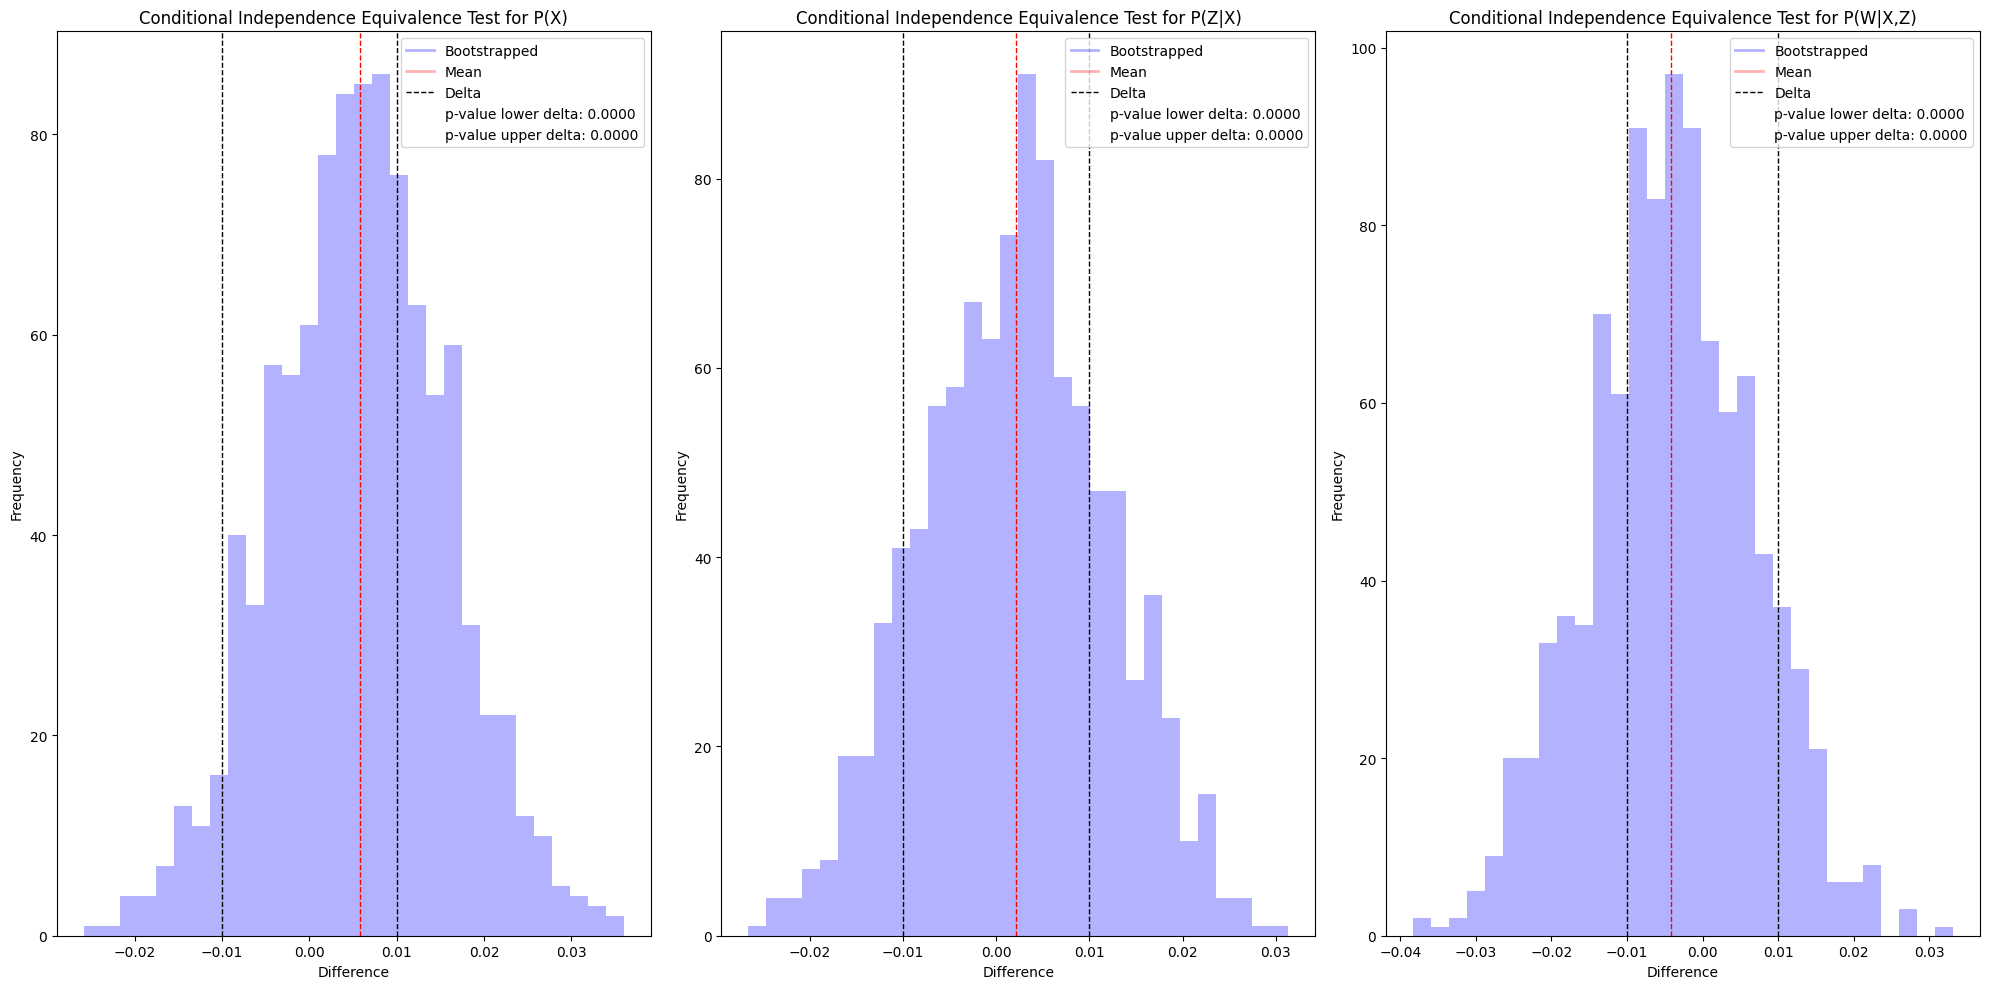

NameError: name 'differences_y_s1s2' is not defined

<Figure size 1000x500 with 0 Axes>

In [77]:
#Histograms for the test results for sample 1 vs sample 2
##Will display results for Y|X,Z,W in the end
fig, ax = plt.subplots(1,3, figsize=(20,10))
#Plot for X variable
ax[0].hist(differences_x_s1s2, bins=30, alpha=0.3, color='blue', label = "Bootstrapped differences")
ax[0].axvline(np.mean(differences_x_s1s2), color='red', linestyle='dashed', linewidth=1, label = "Mean difference")
ax[0].set_title(f"Conditional Independence Equivalence Test for P(X)")
ax[0].set_xlabel("Difference")
ax[0].set_ylabel("Frequency")
#Add the lower and upper delta values as vertical lines
ax[0].axvline(-0.01, color='black', linestyle='dashed', linewidth=1, label = "Delta")
ax[0].axvline(0.01, color='black', linestyle='dashed', linewidth=1, label = "Delta")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3), plt.Line2D([0], [0], color='black', linestyle='dashed', linewidth=1, label='Delta')]
ax[0].legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value lower delta: {p_value_lower_delta_x_s1s2:.4f}'), plt.Line2D([0], [0], color='none', label=f'p-value upper delta: {p_value_upper_delta_x_s1s2:.4f}')])    
#Plot for Z variable
ax[1].hist(differences_z_s1s2, bins=30, alpha=0.3, color='blue', label = "Bootstrapped differences")
ax[1].axvline(np.mean(differences_z_s1s2), color='red', linestyle='dashed', linewidth=1, label = "Mean difference")
ax[1].set_title(f"Conditional Independence Equivalence Test for P(Z|X)")
ax[1].set_xlabel("Difference")
ax[1].set_ylabel("Frequency")
#Add the lower and upper delta values as vertical lines
ax[1].axvline(-0.01, color='black', linestyle='dashed', linewidth=1, label = "Delta")
ax[1].axvline(0.01, color='black', linestyle='dashed', linewidth=1, label = "Delta")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3), plt.Line2D([0], [0], color='black', linestyle='dashed', linewidth=1, label='Delta')]
ax[1].legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value lower delta: {p_value_lower_delta_z_s1s2:.4f}'), plt.Line2D([0], [0], color='none', label=f'p-value upper delta: {p_value_upper_delta_z_s1s2:.4f}')])
#Plot for W variable
ax[2].hist(differences_w_s1s2, bins=30, alpha=0.3, color='blue', label = "Bootstrapped differences")
ax[2].axvline(np.mean(differences_w_s1s2), color='red', linestyle='dashed', linewidth=1, label = "Mean difference")
ax[2].set_title(f"Conditional Independence Equivalence Test for P(W|X,Z)")
ax[2].set_xlabel("Difference")
ax[2].set_ylabel("Frequency")
#Add the lower and upper delta values as vertical lines
ax[2].axvline(-0.01, color='black', linestyle='dashed', linewidth=1, label = "Delta")
ax[2].axvline(0.01, color='black', linestyle='dashed', linewidth=1, label = "Delta")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3), plt.Line2D([0], [0], color='black', linestyle='dashed', linewidth=1, label='Delta')]
ax[2].legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value lower delta: {p_value_lower_delta_w_s1s2:.4f}'), plt.Line2D([0], [0], color='none', label=f'p-value upper delta: {p_value_upper_delta_w_s1s2:.4f}')])
plt.tight_layout()
plt.show()

#Now for Y|X,Z,W
##its only one plot
##change size of plot
plt.figure(figsize=(10,5))
plt.hist(differences_y_s1s2, bins=30, alpha=0.3, color='blue', label = "Bootstrapped differences")
plt.axvline(np.mean(differences_y_s1s2), color='red', linestyle='dashed', linewidth=1, label = "Mean difference")
plt.title(f"Conditional Independence Equivalence Test for P(Y|X,Z,W)")
plt.xlabel("Difference")
plt.ylabel("Frequency")
#Add the lower and upper delta values as vertical lines
plt.axvline(-0.01, color='black', linestyle='dashed', linewidth=1, label = "Delta")
plt.axvline(0.01, color='black', linestyle='dashed', linewidth=1, label = "Delta")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3), plt.Line2D([0], [0], color='black', linestyle='dashed', linewidth=1, label='Delta')]
plt.legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value lower delta: {p_value_lower_delta_y_s1s2:.4f}'), plt.Line2D([0], [0], color='none', label=f'p-value upper delta: {p_value_upper_delta_y_s1s2:.4f}')])


In [ ]:
differences_x_s1s2

In [ ]:
#Perform the test for sample 1 vs sample 3
_, sample_3 = hiring_data(1,n=5000)
'''
##For X:
target = 'X'
causal_parents_source = []
_, p_value_lower_delta_x_s1s3, p_value_upper_delta_x_s1s3, differences_x_s1s3 = equiv_bootstrap_test_schrouff(sample_1, sample_3, target, causal_parents_source)
##For Z:
target = 'Z'
causal_parents_source = ['X']
_, p_value_lower_delta_z_s1s3, p_value_upper_delta_z_s1s3, differences_z_s1s3 = equiv_bootstrap_test_schrouff(sample_1, sample_3, target, causal_parents_source)
##For W:
target = 'W'
causal_parents_source = ['X','Z']
_, p_value_lower_delta_w_s1s3, p_value_upper_delta_w_s1s3, differences_w_s1s3 = equiv_bootstrap_test_schrouff(sample_1, sample_3, target, causal_parents_source)
##For Y:
target = 'Y'
causal_parents_source = ['X','Z','W']
_, p_value_lower_delta_y_s1s3, p_value_upper_delta_y_s1s3, differences_y_s1s3 = equiv_bootstrap_test_schrouff(sample_1, sample_3, target, causal_parents_source)
_, p_value_lower_delta_y_s1s3_05, p_value_upper_delta_y_s1s3_05, differences_y_s1s3_05 = equiv_bootstrap_test_schrouff(sample_1, sample_3, target, causal_parents_source, lower_delta = -0.05)
_, p_value_lower_delta_y_s1s3_10, p_value_upper_delta_y_s1s3_10, differences_y_s1s3_10 = equiv_bootstrap_test_schrouff(sample_1, sample_3, target, causal_parents_source, lower_delta = -0.1)
'''

_, p_value_lower_delta_y_s1s3_10_09, p_value_upper_delta_y_s1s3_10_09, differences_y_s1s3_10_09 = equiv_bootstrap_test_schrouff(sample_1, sample_3, target, causal_parents_source, lower_delta = -0.1, upper_delta = -0.085)



In [ ]:
#Histograms for the test results for sample 1 vs sample 3
#Y|X,Z,W -> performed three different tests
fig, ax = plt.subplots(2,2, figsize=(15,10))
ax[0,0].hist(differences_y_s1s3, bins=30, alpha=0.3, color='blue', label = "Bootstrapped differences")
ax[0,0].axvline(np.mean(differences_y_s1s3), color='red', linestyle='dashed', linewidth=1, label = "Mean difference")
ax[0,0].set_title(f"Cond. Ind. Equiv. Test for P(Y|X,Z,W), with delta = 0.01")
ax[0,0].set_xlabel("Difference")
ax[0,0].set_ylabel("Frequency")
#Add the lower and upper delta values as vertical lines
ax[0,0].axvline(-0.01, color='black', linestyle='dashed', linewidth=1, label = "Delta")
ax[0,0].axvline(0.01, color='black', linestyle='dashed', linewidth=1, label = "Delta")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3), plt.Line2D([0], [0], color='black', linestyle='dashed', linewidth=1, label='Delta')]
ax[0,0].legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value lower delta: {p_value_lower_delta_y_s1s3:.4f}'), plt.Line2D([0], [0], color='none', label=f'p-value upper delta: {p_value_upper_delta_y_s1s3:.4f}')])
ax[0,1].hist(differences_y_s1s3_05, bins=30, alpha=0.3, color='blue', label = "Bootstrapped differences")
ax[0,1].axvline(np.mean(differences_y_s1s3_05), color='red', linestyle='dashed', linewidth=1, label = "Mean difference")
ax[0,1].set_title(f"Cond. Ind. Equiv. Test for P(Y|X,Z,W), with lower delta = -0.05, upper delta = 0.01")
ax[0,1].set_xlabel("Difference")
ax[0,1].set_ylabel("Frequency")
#Add the lower and upper delta values as vertical lines
ax[0,1].axvline(-0.05, color='black', linestyle='dashed', linewidth=1, label = "Delta")
ax[0,1].axvline(0.01, color='black', linestyle='dashed', linewidth=1, label = "Delta")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3), plt.Line2D([0], [0], color='black', linestyle='dashed', linewidth=1, label='Delta')]
ax[0,1].legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value lower delta: {p_value_lower_delta_y_s1s3_05:.4f}'), plt.Line2D([0], [0], color='none', label=f'p-value upper delta: {p_value_upper_delta_y_s1s3_05:.4f}')])
ax[1,0].hist(differences_y_s1s3_10, bins=30, alpha=0.3, color='blue', label = "Bootstrapped differences")
ax[1,0].axvline(np.mean(differences_y_s1s3_10), color='red', linestyle='dashed', linewidth=1, label = "Mean difference")
ax[1,0].set_title(f"Cond. Ind. Equiv. Test for P(Y|X,Z,W), with lower delta = -0.1, upper delta = 0.01")
ax[1,0].set_xlabel("Difference")
ax[1,0].set_ylabel("Frequency")
#Add the lower and upper delta values as vertical lines
ax[1,0].axvline(-0.1, color='black', linestyle='dashed', linewidth=1, label = "Delta")
ax[1,0].axvline(0.01, color='black', linestyle='dashed', linewidth=1, label = "Delta")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3), plt.Line2D([0], [0], color='black', linestyle='dashed', linewidth=1, label='Delta')]
ax[1,0].legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value lower delta: {p_value_lower_delta_y_s1s3_10:.4f}'), plt.Line2D([0], [0], color='none', label=f'p-value upper delta: {p_value_upper_delta_y_s1s3_10:.4f}')])
ax[1,1].hist(differences_y_s1s3_10_09, bins=30, alpha=0.3, color='blue', label = "Bootstrapped differences")
ax[1,1].axvline(np.mean(differences_y_s1s3_10_09), color='red', linestyle='dashed', linewidth=1, label = "Mean difference")
ax[1,1].set_title(f"Cond. Ind. Equiv. Test for P(Y|X,Z,W), with lower delta = -0.1, upper delta = -0.085")
ax[1,1].set_xlabel("Difference")
ax[1,1].set_ylabel("Frequency")
#Add the lower and upper delta values as vertical lines
ax[1,1].axvline(-0.1, color='black', linestyle='dashed', linewidth=1, label = "Delta")
ax[1,1].axvline(-0.085, color='black', linestyle='dashed', linewidth=1, label = "Delta")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3), plt.Line2D([0], [0], color='black', linestyle='dashed', linewidth=1, label='Delta')]
ax[1,1].legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value lower delta: {p_value_lower_delta_y_s1s3_10_09:.4f}'), plt.Line2D([0], [0], color='none', label=f'p-value upper delta: {p_value_upper_delta_y_s1s3_10_09:.4f}')])
plt.tight_layout()
plt.show()

In [ ]:
#Perform the test for sample 1 vs sample 4 (only for Y|X,Z,W)
target = 'Y'
causal_parents_source = ['X','Z','W']
#_, p_value_lower_delta_y_s1s4, p_value_upper_delta_y_s1s4, differences_y_s1s4 = equiv_bootstrap_test_schrouff(sample_1, sample_4, target, causal_parents_source, split = 0.5)
#repeat with delta -0.06 and -0.04
_, p_value_lower_delta_y_s1s4_06, p_value_upper_delta_y_s1s4_06, differences_y_s1s4_06 = equiv_bootstrap_test_schrouff(sample_1, sample_4, target, causal_parents_source, split = 0.5, lower_delta = -0.03, upper_delta=-0.02)



In [ ]:
#Visualize the results for sample 1 vs sample 4
fig, ax = plt.subplots(1,2, figsize=(15,7.5))
ax[0].hist(differences_y_s1s4, bins=30, alpha=0.3, color='blue', label = "Bootstrapped differences")
ax[0].axvline(np.mean(differences_y_s1s4), color='red', linestyle='dashed', linewidth=1, label = "Mean difference")
ax[0].set_title(f"Cond. Ind. Equiv. Test for P(Y|X,Z,W), with delta = 0.01")
ax[0].set_xlabel("Difference")
ax[0].set_ylabel("Frequency")
#Add the lower and upper delta values as vertical lines
ax[0].axvline(-0.01, color='black', linestyle='dashed', linewidth=1, label = "Delta")
ax[0].axvline(0.01, color='black', linestyle='dashed', linewidth=1, label = "Delta")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3), plt.Line2D([0], [0], color='black', linestyle='dashed', linewidth=1, label='Delta')]
ax[0].legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value lower delta: {p_value_lower_delta_y_s1s4:.4f}'), plt.Line2D([0], [0], color='none', label=f'p-value upper delta: {p_value_upper_delta_y_s1s4:.4f}')])
ax[1].hist(differences_y_s1s4_06, bins=30, alpha=0.3, color='blue', label = "Bootstrapped differences")
ax[1].axvline(np.mean(differences_y_s1s4_06), color='red', linestyle='dashed', linewidth=1, label = "Mean difference")
ax[1].set_title(f"Cond. Ind. Equiv. Test for P(Y|X,Z,W), with lower delta = -0.03 upper delta = -0.02")
ax[1].set_xlabel("Difference")
ax[1].set_ylabel("Frequency")
#Add the lower and upper delta values as vertical lines
ax[1].axvline(-0.03, color='black', linestyle='dashed', linewidth=1, label = "Delta")
ax[1].axvline(-0.02, color='black', linestyle='dashed', linewidth=1, label = "Delta")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3), plt.Line2D([0], [0], color='black', linestyle='dashed', linewidth=1, label='Delta')]
ax[1].legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value lower delta: {p_value_lower_delta_y_s1s4_06:.4f}'), plt.Line2D([0], [0], color='none', label=f'p-value upper delta: {p_value_upper_delta_y_s1s4_06:.4f}')])
plt.tight_layout()
plt.show()


In [ ]:
#Define function to perform weighted bootstrap test
def indiv_equiv_bootstrap_test_schrouff(sample_a,sample_b,target, causal_parents_source,value,conditional='X',  B=10000, split=0.75,lower_delta = -0.01, upper_delta = 0.01):

    np.random.seed(36)
    '''
    Function to perform weighted bootstrap test for difference in conditional probabilities of Y=1 given X,Z,W for two samples
    as described in Schrouff et al. (2022)

    Parameters:

    sample_a: pandas DataFrame containing sample A
    sample_b: pandas DataFrame containing sample B
    causal_parents_source: list of strings containing causal paraents of variable of interest (i.e. PA(Y) = {X,Z,W})
    B: int, number of bootstrap iterations
    split: float, proportion of samples to use for estimating the weights using logistic regression

    Returns:

    bootstrapped_t_stats: numpy array containing bootstrapped t-statistics for each tested conditional probability
    bootstrapped_mean_probabilities: numpy array containing the mean bootstrapped probabilities for each tested conditional probability
    bootstrapped_weights_mean: numpy array containing the mean bootstrapped weights for each sample
    bootstrapped_weighted_means: numpy array containing the bootstrapped weighted means for each sample
    bootstrapped_pooled_se: numpy array containing the bootstrapped pooled standard errors for each tested conditional probability
    p_values: float containing the p-value obtained from a two-sided z-test of the bootstrapped t-statistics distribution against 0
    '''



    #Step 1: Split initial samples into weighting and testing sets
    ##Split the samples
    sample_a_weights = sample_a.sample(frac=split)
    sample_b_weights = sample_b.sample(frac=split)
    sample_a_testing = sample_a[~sample_a.index.isin(sample_a_weights.index)]
    sample_b_testing = sample_b[~sample_b.index.isin(sample_b_weights.index)]
    ##initialize empty arrays to store bootstrapped t-statistics, bootstrapped probabilities, mean bootstrapped weights and bootstrapped weighted means
    bootstrapped_t_stats = np.empty((2,B))
    differences = np.empty(B)
    #Step2: perform bootstrap
    
    if len(causal_parents_source) >0:

        for i in tqdm.tqdm(range(B), desc='Bootstrapping'):
            #Test, for each bootstrap iteration have a different set for weights and testing
            #Step 2.1: Sample with replacement from the weights and testing
            bootstrap_sample_a_weights = sample_a_weights.sample(n=len(sample_a_weights), replace=True)
            bootstrap_sample_b_weights = sample_b_weights.sample(n=len(sample_b_weights), replace=True)
            bootstrap_sample_a_testing = sample_a_testing.sample(n=len(sample_a_testing), replace=True)
            bootstrap_sample_b_testing = sample_b_testing.sample(n=len(sample_b_testing), replace=True)

            #Step 2.2: Fit logistic regression model to estimate weights
            ##Pool the samples
            pooled_weights = pd.concat([bootstrap_sample_a_weights, bootstrap_sample_b_weights])
            ##Add sample indicator
            pooled_weights['Sample'] = ['Sample A']*len(bootstrap_sample_a_weights) + ['Sample B']*len(bootstrap_sample_b_weights)
            ##Feature matrix X with intercept
            X = sm.add_constant(pooled_weights[causal_parents_source])
            ##Target vector Y with sample 1 as reference
            Y = (pooled_weights['Sample'] == 'Sample B').astype(int)
            ##Fit logistic regression model
            logit_model = sm.Logit(Y, X).fit(disp=0)
            ##extract weights on testing set
            X_a = sm.add_constant(bootstrap_sample_a_testing[causal_parents_source])
            X_b = sm.add_constant(bootstrap_sample_b_testing[causal_parents_source])
            #filter X_a by the conditional attribute (X=1)
            X_a = X_a[X_a[conditional] == value]
            X_b = X_b[X_b[conditional] == value]
            p_a = logit_model.predict(X_a)
            p_a = 1-p_a #need to compute 1-pa, because the logit model predicts the probability of being in class b
            p_b = logit_model.predict(X_b)
            #Store the mean probability for p_a
            if np.any(p_a == 0) or np.any(p_b == 0):
                print('Warning: Zero values in p_a or p_b')
            if np.any(p_a < 1e-10) or np.any(p_b < 1e-10):  # Threshold can vary based on the scale of your data
                print('Warning: Near-zero values in p_a or p_b')
            #Compute the weights
            w_a = 1/p_a
            w_b = 1/p_b
            #Normalize the weights
            w_a_norm = w_a/np.sum(w_a)
            w_b_norm = w_b/np.sum(w_b)
            #Check for nans and infs
            if np.any(np.isnan(w_a)) or np.any(np.isnan(w_b)):
                print('Warning: NaN values in w_a or w_b')
            if np.any(np.isinf(w_a)) or np.any(np.isinf(w_b)):
                print('Warning: Inf values in w_a or w_b')
            #Check for very small values
            if np.any(w_a < 1e-10) or np.any(w_b < 1e-10):
                print('Warning: Near-zero values in w_a or w_b')
            
            #Compute hadamard product
            #filter Y_a by the conditional attribute (X=1)
            relevant_a = bootstrap_sample_a_testing[bootstrap_sample_a_testing[conditional] == value]
            relevant_b = bootstrap_sample_b_testing[bootstrap_sample_b_testing[conditional] == value]
            Y_a = relevant_a[target].values
            Y_b = relevant_b[target].values
            product_a = w_a_norm.values*Y_a
            product_b = w_b_norm.values*Y_b
            sum_a = np.sum(product_a)
            sum_b = np.sum(product_b)
            difference = sum_a - sum_b
            differences[i] = difference

            '''
            together = np.concatenate([product_a,-product_b])
            bootstrapped_t_stats[0,i] = ttest_1samp(together, -delta, alternative = 'greater')[0]
            bootstrapped_t_stats[1,i] = ttest_1samp(together, delta, alternative = 'less')[0]
            '''

    else:
         for i in tqdm.tqdm(range(B), desc='Bootstrapping'):
             #sample with replacement from testing
            bootstrap_sample_a_testing = sample_a_testing.sample(n=len(sample_a_testing), replace=True)
            bootstrap_sample_b_testing = sample_b_testing.sample(n=len(sample_b_testing), replace=True)
            #Compute hadamard product
            Y_a = bootstrap_sample_a_testing[target].values
            Y_b = bootstrap_sample_b_testing[target].values
            difference = Y_a - Y_b
            differences[i] = np.mean(difference)




    #Compute t-statistic
    _, p_value_lower_delta = ttest_1samp(differences, lower_delta, alternative = 'greater')
    _, p_value_upper_delta = ttest_1samp(differences, upper_delta, alternative = 'less')
    
    '''
    #Step 3: Compute p-values
    mean_greater = np.mean(bootstrapped_t_stats[0])
    std_greater = np.std(bootstrapped_t_stats[0])
    mean_less = np.mean(bootstrapped_t_stats[1])
    std_less = np.std(bootstrapped_t_stats[1])
    p_value_greater = (2*norm.cdf(-abs((mean_greater)/std_greater)))
    p_value_less = (2*norm.cdf(-abs((mean_less)/std_less)))
    '''
    return bootstrapped_t_stats, p_value_lower_delta, p_value_upper_delta, differences

In [ ]:
#Perform the test for sample 1 vs sample 4
##filtering by x=1
target = 'Y'
causal_parents_source = ['X','Z','W']
value = 1
conditional = 'X'
_, p_value_lower_delta_y_x1_s1s4, p_value_upper_delta_y_x1_s1s4, differences_y_x1_s1s4 = indiv_equiv_bootstrap_test_schrouff(sample_1, sample_4, target, causal_parents_source,value,conditional, split = 0.5, lower_delta = -0.55, upper_delta = -0.045)
#now for value = 0
value = 0
_, p_value_lower_delta_y_x0_s1s4, p_value_upper_delta_y_x0_s1s4, differences_y_x0_s1s4 = indiv_equiv_bootstrap_test_schrouff(sample_1, sample_4, target, causal_parents_source,value,conditional, split = 0.5, lower_delta = -0.55, upper_delta = -0.045)
#now again for value = 0, but delta = -0.01, 0.01
_, p_value_lower_delta_y_x0_s1s4_01, p_value_upper_delta_y_x0_s1s4_01, differences_y_x0_s1s4_01 = indiv_equiv_bootstrap_test_schrouff(sample_1, sample_4, target, causal_parents_source,value,conditional, split = 0.5, lower_delta = -0.01, upper_delta = 0.01)

In [ ]:
#Visualize the results for sample 1 vs sample 4
fig, ax = plt.subplots(3,1, figsize=(10,7.5))
ax[0].hist(differences_y_x1_s1s4, bins=30, alpha=0.3, color='blue', label = "Bootstrapped differences")
ax[0].axvline(np.mean(differences_y_x1_s1s4), color='red', linestyle='dashed', linewidth=1, label = "Mean difference")
ax[0].set_title(f"Cond. Ind. Equiv. Test:P(Y|X=1,Z,W), with lower delta = -0.55, upper delta = -0.045")
ax[0].set_xlabel("Difference")
ax[0].set_ylabel("Frequency")
#Add the lower and upper delta values as vertical lines
ax[0].axvline(-0.055, color='black', linestyle='dashed', linewidth=1, label = "Delta")
ax[0].axvline(-0.045, color='black', linestyle='dashed', linewidth=1, label = "Delta")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3), plt.Line2D([0], [0], color='black', linestyle='dashed', linewidth=1, label='Delta')]
ax[0].legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value lower delta: {p_value_lower_delta_y_x1_s1s4:.4f}'), plt.Line2D([0], [0], color='none', label=f'p-value upper delta: {p_value_upper_delta_y_x1_s1s4:.4f}')])
ax[1].hist(differences_y_x0_s1s4, bins=30, alpha=0.3, color='blue', label = "Bootstrapped differences")
ax[1].axvline(np.mean(differences_y_x0_s1s4), color='red', linestyle='dashed', linewidth=1, label = "Mean difference")
ax[1].set_title(f"Cond. Ind. Equiv. Test:P(Y|X=0,Z,W), with lower delta = -0.55, upper delta = -0.045")
ax[1].set_xlabel("Difference")
ax[1].set_ylabel("Frequency")
#Add the lower and upper delta values as vertical lines
ax[1].axvline(-0.055, color='black', linestyle='dashed', linewidth=1, label = "Delta")
ax[1].axvline(-0.045, color='black', linestyle='dashed', linewidth=1, label = "Delta")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3), plt.Line2D([0], [0], color='black', linestyle='dashed', linewidth=1, label='Delta')]
ax[1].legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value lower delta: {p_value_lower_delta_y_x0_s1s4:.4f}'), plt.Line2D([0], [0], color='none', label=f'p-value upper delta: {p_value_upper_delta_y_x0_s1s4:.4f}')])
ax[2].hist(differences_y_x0_s1s4_01, bins=30, alpha=0.3, color='blue', label = "Bootstrapped differences")
ax[2].axvline(np.mean(differences_y_x0_s1s4_01), color='red', linestyle='dashed', linewidth=1, label = "Mean difference")
ax[2].set_title(f"Cond. Ind. Equiv. Test:P(Y|X=0,Z,W), with lower delta = -0.01, upper delta = 0.01")
ax[2].set_xlabel("Difference")
ax[2].set_ylabel("Frequency")
#Add the lower and upper delta values as vertical lines
ax[2].axvline(-0.01, color='black', linestyle='dashed', linewidth=1, label = "Delta")
ax[2].axvline(0.01, color='black', linestyle='dashed', linewidth=1, label = "Delta")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3), plt.Line2D([0], [0], color='black', linestyle='dashed', linewidth=1, label='Delta')]
ax[2].legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value lower delta: {p_value_lower_delta_y_x0_s1s4_01:.4f}'), plt.Line2D([0], [0], color='none', label=f'p-value upper delta: {p_value_upper_delta_y_x0_s1s4_01:.4f}')])
plt.tight_layout()
plt.show()


In [ ]:
#Read the following .csv files:
#fair_predictions_source_output.csv
#fair_predictions_target_output.csv
sample_1 = pd.read_csv('fair_predictions_source_output.csv')
sample_2 = pd.read_csv('fair_predictions_target_output.csv')

#change predictions column such that 1 if > 0.5, 0 otherwise
sample_1['predictions'] = (sample_1['predictions'] > 0.5).astype(int)
sample_2['predictions'] = (sample_2['predictions'] > 0.5).astype(int)



In [ ]:
x_de = 0
x_ie = 0
x_se = 0
changed_factor_de = 0
changed_factor_ie = 0

for z in [0,1]:
    p_z_x0 = sample_1[(sample_1['Z']==z) & (sample_1['X']==0)].shape[0]/sample_1[sample_1['X']==0].shape[0]
    p_z_x1 = sample_1[(sample_1['Z']==z) & (sample_1['X']==1)].shape[0]/sample_1[sample_1['X']==1].shape[0]
    for w in [0,1]:
        p_w_z_x0 = sample_1[(sample_1['W']==w) & (sample_1['Z']==z) & (sample_1['X']==0)].shape[0]/sample_1[(sample_1['Z']==z) & (sample_1['X']==0)].shape[0]
        p_w_z_x1 = sample_1[(sample_1['W']==w) & (sample_1['Z']==z) & (sample_1['X']==1)].shape[0]/sample_1[(sample_1['Z']==z) & (sample_1['X']==1)].shape[0]

        p_y_w_z_x0 = sample_1[(sample_1['predictions']==1) & (sample_1['W']==w) & (sample_1['Z']==z) & (sample_1['X']==0)].shape[0]/sample_1[(sample_1['W']==w) & (sample_1['Z']==z) & (sample_1['X']==0)].shape[0]
        p_y_w_z_x1 = sample_1[(sample_1['predictions']==1) & (sample_1['W']==w) & (sample_1['Z']==z) & (sample_1['X']==1)].shape[0]/sample_1[(sample_1['W']==w) & (sample_1['Z']==z) & (sample_1['X']==1)].shape[0]

        x_de += (p_y_w_z_x1-p_y_w_z_x0)*p_w_z_x0*p_z_x0
        x_ie += p_y_w_z_x1*(p_w_z_x0-p_w_z_x1)*p_z_x0
        x_se += p_y_w_z_x1*p_w_z_x1*(p_z_x0-p_z_x1)
        changed_factor_de += p_w_z_x0*p_z_x0
        changed_factor_ie += (p_w_z_x0-p_w_z_x1)*p_z_x0


print(x_de)
print(x_ie)
print(x_se)
print(changed_factor_de)
print(np.round(changed_factor_ie))
        

#Repeat for sample 2
x_de = 0
x_ie = 0
x_se = 0


for z in [0,1]:
    p_z_x0 = sample_2[(sample_2['Z']==z) & (sample_2['X']==0)].shape[0]/sample_2[sample_2['X']==0].shape[0]
    p_z_x1 = sample_2[(sample_2['Z']==z) & (sample_2['X']==1)].shape[0]/sample_2[sample_2['X']==1].shape[0]
    for w in [0,1]:
        p_w_z_x0 = sample_2[(sample_2['W']==w) & (sample_2['Z']==z) & (sample_2['X']==0)].shape[0]/sample_2[(sample_2['Z']==z) & (sample_2['X']==0)].shape[0]
        p_w_z_x1 = sample_2[(sample_2['W']==w) & (sample_2['Z']==z) & (sample_2['X']==1)].shape[0]/sample_2[(sample_2['Z']==z) & (sample_2['X']==1)].shape[0]

        p_y_w_z_x0 = sample_2[(sample_2['predictions']==1) & (sample_2['W']==w) & (sample_2['Z']==z) & (sample_2['X']==0)].shape[0]/sample_2[(sample_2['W']==w) & (sample_2['Z']==z) & (sample_2['X']==0)].shape[0]
        p_y_w_z_x1 = sample_2[(sample_2['predictions']==1) & (sample_2['W']==w) & (sample_2['Z']==z) & (sample_2['X']==1)].shape[0]/sample_2[(sample_2['W']==w) & (sample_2['Z']==z) & (sample_2['X']==1)].shape[0]

        x_de += (p_y_w_z_x1-p_y_w_z_x0)*p_w_z_x0*p_z_x0
        x_ie += p_y_w_z_x1*(p_w_z_x0-p_w_z_x1)*p_z_x0
        x_se += p_y_w_z_x1*p_w_z_x1*(p_z_x0-p_z_x1)



print(x_de)
print(x_ie)
print(x_se)



In [ ]:
from folktables import ACSDataSource, ACSIncome
import numpy as np  
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import entropy, chi2_contingency, norm, ttest_1samp
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

In [ ]:
#Construct the data source
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
#Get the data for California, Michigan, Florida and Utah, Illinois, Texas, New York
ca_data = data_source.get_data(states=["CA"], download=True)
mi_data = data_source.get_data(states=["MI"], download=True)
fl_data = data_source.get_data(states=["FL"], download=True)
ut_data = data_source.get_data(states=["UT"], download=True)
il_data = data_source.get_data(states=["IL"], download=True)
tx_data = data_source.get_data(states=["TX"], download=True)
ny_data = data_source.get_data(states=["NY"], download=True)
bo_data = data_source.get_data(states=["MA"], download=True)

#Filter columns 'AGEP' to contain only people older than 18
ca_data = ca_data[ca_data['AGEP'] > 18]
mi_data = mi_data[mi_data['AGEP'] > 18]
fl_data = fl_data[fl_data['AGEP'] > 18]
ut_data = ut_data[ut_data['AGEP'] > 18]
il_data = il_data[il_data['AGEP'] > 18]
tx_data = tx_data[tx_data['AGEP'] > 18]
ny_data = ny_data[ny_data['AGEP'] > 18]
bo_data = bo_data[bo_data['AGEP'] > 18]

#Filter column 'PINCP' to contain only people with income > 100
ca_data = ca_data[ca_data['PINCP'] > 100]
mi_data = mi_data[mi_data['PINCP'] > 100]
fl_data = fl_data[fl_data['PINCP'] > 100]
ut_data = ut_data[ut_data['PINCP'] > 100]
il_data = il_data[il_data['PINCP'] > 100]
tx_data = tx_data[tx_data['PINCP'] > 100]
ny_data = ny_data[ny_data['PINCP'] > 100]
bo_data = bo_data[bo_data['PINCP'] > 100]

#Filter column WKHP to contain only people working more than 0 hours
ca_data = ca_data[ca_data['WKHP'] > 0]
mi_data = mi_data[mi_data['WKHP'] > 0]
fl_data = fl_data[fl_data['WKHP'] > 0]
ut_data = ut_data[ut_data['WKHP'] > 0]
il_data = il_data[il_data['WKHP'] > 0]
tx_data = tx_data[tx_data['WKHP'] > 0]
ny_data = ny_data[ny_data['WKHP'] > 0]
bo_data = bo_data[bo_data['WKHP'] > 0]

In [ ]:
#Extract data for the task
Y = "PINCP"
X = "SEX"
Z_demographic = ["AGEP","RAC1P"]
W_intermediate = ["MAR","SCHL","COW","OCCP","RELP"]

#Extract the data
ca_Y = ca_data[Y]
ca_X = ca_data[X]
ca_Z = ca_data[Z_demographic]
ca_W = ca_data[W_intermediate]
ca_df = pd.concat([ca_Y, ca_Z, ca_W,ca_X], axis=1)

mi_Y = mi_data[Y]
mi_X = mi_data[X]
mi_Z = mi_data[Z_demographic]
mi_W = mi_data[W_intermediate]
mi_df = pd.concat([mi_Y, mi_Z, mi_W,mi_X], axis=1)

fl_Y = fl_data[Y]
fl_X = fl_data[X]
fl_Z = fl_data[Z_demographic]
fl_W = fl_data[W_intermediate]
fl_df = pd.concat([fl_Y, fl_Z, fl_W,fl_X], axis=1)

ut_Y = ut_data[Y]
ut_X = ut_data[X]
ut_Z = ut_data[Z_demographic]
ut_W = ut_data[W_intermediate]
ut_df = pd.concat([ut_Y, ut_Z, ut_W,ut_X], axis=1)

il_Y = il_data[Y]
il_X = il_data[X]
il_Z = il_data[Z_demographic]
il_W = il_data[W_intermediate]
il_df = pd.concat([il_Y, il_Z, il_W,il_X], axis=1)

tx_Y = tx_data[Y]
tx_X = tx_data[X]
tx_Z = tx_data[Z_demographic]
tx_W = tx_data[W_intermediate]
tx_df = pd.concat([tx_Y, tx_Z, tx_W,tx_X], axis=1)

ny_Y = ny_data[Y]
ny_X = ny_data[X]
ny_Z = ny_data[Z_demographic]
ny_W = ny_data[W_intermediate]
ny_df = pd.concat([ny_Y, ny_Z, ny_W,ny_X], axis=1)

bo_Y = bo_data[Y]  
bo_X = bo_data[X]
bo_Z = bo_data[Z_demographic]
bo_W = bo_data[W_intermediate]
bo_df = pd.concat([bo_Y, bo_Z, bo_W,bo_X], axis=1)




#Discretize the Age variable in bins of 20 years
# Define the bin edges
bins = [18, 40, 60, 80, 100]
# Create labels for each bin
labels = ['18-40', '40-60', '60-80', '80-100']
# Use pd.cut to bin the 'AGEP' column into categories
ca_df['AGEP'] = pd.cut(ca_df['AGEP'], bins=bins, labels=labels, right=False)
mi_df['AGEP'] = pd.cut(mi_df['AGEP'], bins=bins, labels=labels, right=False)
fl_df['AGEP'] = pd.cut(fl_df['AGEP'], bins=bins, labels=labels, right=False)
ut_df['AGEP'] = pd.cut(ut_df['AGEP'], bins=bins, labels=labels, right=False)
il_df['AGEP'] = pd.cut(il_df['AGEP'], bins=bins, labels=labels, right=False)
tx_df['AGEP'] = pd.cut(tx_df['AGEP'], bins=bins, labels=labels, right=False)
ny_df['AGEP'] = pd.cut(ny_df['AGEP'], bins=bins, labels=labels, right=False)
bo_df['AGEP'] = pd.cut(bo_df['AGEP'], bins=bins, labels=labels, right=False)
#Drop rows with NaN values
ca_df = ca_df.dropna()
mi_df = mi_df.dropna()
fl_df = fl_df.dropna()
ut_df = ut_df.dropna()
il_df = il_df.dropna()
tx_df = tx_df.dropna()
ny_df = ny_df.dropna()
bo_df = bo_df.dropna()
#Convert SCHL to integer
ca_df['SCHL'] = ca_df['SCHL'].astype(int)
mi_df['SCHL'] = mi_df['SCHL'].astype(int)
fl_df['SCHL'] = fl_df['SCHL'].astype(int)
ut_df['SCHL'] = ut_df['SCHL'].astype(int)
il_df['SCHL'] = il_df['SCHL'].astype(int)
tx_df['SCHL'] = tx_df['SCHL'].astype(int)
ny_df['SCHL'] = ny_df['SCHL'].astype(int)
bo_df['SCHL'] = bo_df['SCHL'].astype(int)
#Discretize PINCP in >50K and <=50K
ca_df['PINCP'] = ca_df['PINCP'].apply(lambda x: 1 if x>50000 else 0)
mi_df['PINCP'] = mi_df['PINCP'].apply(lambda x: 1 if x>50000 else 0)
fl_df['PINCP'] = fl_df['PINCP'].apply(lambda x: 1 if x>50000 else 0)
ut_df['PINCP'] = ut_df['PINCP'].apply(lambda x: 1 if x>50000 else 0)
il_df['PINCP'] = il_df['PINCP'].apply(lambda x: 1 if x>50000 else 0)
tx_df['PINCP'] = tx_df['PINCP'].apply(lambda x: 1 if x>50000 else 0)
ny_df['PINCP'] = ny_df['PINCP'].apply(lambda x: 1 if x>50000 else 0)
bo_df['PINCP'] = bo_df['PINCP'].apply(lambda x: 1 if x>50000 else 0)

#Discretize education 
# Define a function to discretize SCHL values
def discretize_schl(value):
    if value == 0 or value == 1 or value == 2 or value == 3:  # Early Childhood Education
        return 0
    elif 4 <= value <= 8:  # Elementary School
        return 1
    elif 9 <= value <= 11:  # Middle School
        return 2
    elif 12 <= value <= 17:  # High School
        return 3
    elif 18 <= value <= 19:  # Some College
        return 4
    elif value == 20:  # Associate’s Degree
        return 5
    elif value == 21:  # Bachelor’s Degree
        return 6
    elif value >= 22:  # Graduate Degrees
        return 7
    else:
        return None  # Handle unexpected values

# Apply the function to the SCHL column
ca_df['SCHL'] = ca_df['SCHL'].apply(discretize_schl)
mi_df['SCHL'] = mi_df['SCHL'].apply(discretize_schl)
fl_df['SCHL'] = fl_df['SCHL'].apply(discretize_schl)
ut_df['SCHL'] = ut_df['SCHL'].apply(discretize_schl)
il_df['SCHL'] = il_df['SCHL'].apply(discretize_schl)
tx_df['SCHL'] = tx_df['SCHL'].apply(discretize_schl)
ny_df['SCHL'] = ny_df['SCHL'].apply(discretize_schl)
bo_df['SCHL'] = bo_df['SCHL'].apply(discretize_schl)

# Function to discretize RELP based on level of dependence
def discretize_relp(relp_value):
    if relp_value in [0, 1]:
        return 'Self and Spouse'
    elif relp_value in [2, 3, 4, 7, 14]:
        return 'Direct Dependents'
    elif relp_value in [5, 12, 13]:
        return 'Peers and Similar Relations'
    elif relp_value in [6, 8]:
        return 'Older Generation'
    elif relp_value in [9, 10]:
        return 'Extended and Distant Relatives'
    elif relp_value in [11, 15]:
        return 'Lodgers and Non-Family Members'
    elif relp_value in [16, 17]:
        return 'Institutional Residents'
    else:
        return 'Unknown'

# Apply the function to each DataFrame
for df in [ca_df, mi_df, fl_df, ut_df, il_df, tx_df, ny_df, bo_df]:
    df['RELP_category'] = df['RELP'].apply(discretize_relp)

#Change sex such that values encoded as 2 are assigned 0
ca_df['SEX'] = ca_df['SEX'].replace(2, 0)
fl_df['SEX'] = fl_df['SEX'].replace(2, 0)
tx_df['SEX'] = tx_df['SEX'].replace(2, 0)
ut_df['SEX'] = ut_df['SEX'].replace(2, 0)
mi_df['SEX'] = mi_df['SEX'].replace(2, 0)
ny_df['SEX'] = ny_df['SEX'].replace(2, 0)
il_df['SEX'] = il_df['SEX'].replace(2, 0)
bo_df['SEX'] = bo_df['SEX'].replace(2, 0)

ca_df['RAC1P'] = ca_df['RAC1P'].apply(lambda x: 1 if x == 1 else 0)
fl_df['RAC1P'] = fl_df['RAC1P'].apply(lambda x: 1 if x == 1 else 0)
tx_df['RAC1P'] = tx_df['RAC1P'].apply(lambda x: 1 if x == 1 else 0)
ut_df['RAC1P'] = ut_df['RAC1P'].apply(lambda x: 1 if x == 1 else 0)
mi_df['RAC1P'] = mi_df['RAC1P'].apply(lambda x: 1 if x == 1 else 0)
ny_df['RAC1P'] = ny_df['RAC1P'].apply(lambda x: 1 if x == 1 else 0)
il_df['RAC1P'] = il_df['RAC1P'].apply(lambda x: 1 if x == 1 else 0)
bo_df['RAC1P'] = bo_df['RAC1P'].apply(lambda x: 1 if x == 1 else 0)


#SAVE ALL DF as CSV
ca_df.to_csv('ca_df.csv')
mi_df.to_csv('mi_df.csv')
fl_df.to_csv('fl_df.csv')
ut_df.to_csv('ut_df.csv')
il_df.to_csv('il_df.csv')
tx_df.to_csv('tx_df.csv')
ny_df.to_csv('ny_df.csv')



In [ ]:
fl_df['SCHL']

In [58]:
#ca_df['SEX'].mean(), ny_df['SEX'].mean(),fl_df['SEX'].mean(),tx_df['SEX'].mean(),
#set seed 
np.random.seed(1)
#sample randomly 5000 from each df
ca_df_sample = ca_df.sample(n=10000)
#mi_df_sample = mi_df.sample(n=100000)
fl_df_sample = fl_df.sample(n=10000)
#add the observations that that have (fl_df_sample_processed['SEX']==0) & (fl_df_sample_processed['RAC1P']==0) & (fl_df_sample_processed['SCHL']==1)] to fl_df_sample
#fl_df_sample = pd.concat([fl_df_sample,fl_df[(fl_df['SEX']==0) & (fl_df['RAC1P']==0) & (fl_df['SCHL']==1)]])
ut_df_sample = ut_df.sample(n=10000)
il_df_sample = il_df.sample(n=10000)
tx_df_sample = tx_df.sample(n=10000) 
ny_df_sample = ny_df.sample(n=10000)
bo_df_sample = bo_df.sample(n=10000)

def process_dataframe(df):
    # Step 1: Keep only the specified columns
    df_filtered = df[['PINCP', 'SEX', 'SCHL', 'RAC1P']]

    # Step 2: Recode the SCHL column
    df_filtered['SCHL'] = df_filtered['SCHL'].apply(lambda x: 1 if x >= 5 else 0)


    return df_filtered

# Process the dataframes
ca_df_sample_processed = process_dataframe(ca_df_sample)
#mi_df_sample_processed = process_dataframe(mi_df_sample)
fl_df_sample_processed = process_dataframe(fl_df_sample)
ut_df_sample_processed = process_dataframe(ut_df_sample)
il_df_sample_processed = process_dataframe(il_df_sample)
tx_df_sample_processed = process_dataframe(tx_df_sample)
ny_df_sample_processed = process_dataframe(ny_df_sample)
bo_df_sample_processed = process_dataframe(bo_df_sample)

ca_df_sample_processed['PINCP'].mean(), ny_df_sample_processed['PINCP'].mean(), fl_df_sample_processed['PINCP'].mean(), tx_df_sample_processed['PINCP'].mean(), il_df_sample_processed['PINCP'].mean(), ut_df_sample_processed['PINCP'].mean(), bo_df_sample_processed['PINCP'].mean()


(0.4164, 0.4256, 0.3385, 0.3768, 0.4057, 0.3529, 0.4838)

In [64]:
ny_df_sample_processed['RAC1P'].mean(), ut_df_sample_processed['RAC1P'].mean()

(0.7156, 0.8951)

In [ ]:
#Histogram of differences
#for p(sex)
#set plot size
plt.figure(figsize=(10,7.5))
plt.hist(differences_x_fl_ny, bins=30, alpha=0.3, color='blue', label = "Bootstrapped differences")
plt.axvline(np.mean(differences_x_fl_ny), color='red', linestyle='dashed', linewidth=1, label = "Mean difference")
plt.title("Cond. Ind. Equiv. Test:P(X), with lower delta = -0.01, upper delta = 0.01")
plt.xlabel("Difference")
plt.ylabel("Frequency")
#Add the lower and upper delta values as vertical lines
plt.axvline(-0.01, color='black', linestyle='dashed', linewidth=1, label = "Delta")
plt.axvline(0.01, color='black', linestyle='dashed', linewidth=1, label = "Delta")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3), plt.Line2D([0], [0], color='black', linestyle='dashed', linewidth=1, label='Delta')]
plt.legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value lower delta: {p_value_lower_delta_x_fl_ny:.4f}'), plt.Line2D([0], [0], color='none', label=f'p-value upper delta: {p_value_upper_delta_x_fl_ny:.4f}')])
plt.show()
#for p(RAC1P|SEX)
#set plot size
plt.figure(figsize=(10,7.5))
plt.hist(differences_z_fl_ny, bins=30, alpha=0.3, color='blue', label = "Bootstrapped differences")
plt.axvline(np.mean(differences_z_fl_ny), color='red', linestyle='dashed', linewidth=1, label = "Mean difference")
plt.title("Cond. Ind. Equiv. Test:P(Z|X), with lower delta = 0.09, upper delta = 0.1")
plt.xlabel("Difference")
plt.ylabel("Frequency")
#Add the lower and upper delta values as vertical lines
plt.axvline(0.09, color='black', linestyle='dashed', linewidth=1, label = "Delta")
plt.axvline(0.1, color='black', linestyle='dashed', linewidth=1, label = "Delta")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3), plt.Line2D([0], [0], color='black', linestyle='dashed', linewidth=1, label='Delta')]
plt.legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value lower delta: {p_value_lower_delta_z_fl_ny:.4f}'), plt.Line2D([0], [0], color='none', label=f'p-value upper delta: {p_value_upper_delta_z_fl_ny:.4f}')])
plt.show()
#for p(SCHL|SEX,RAC1P)
#set plot size
plt.figure(figsize=(10,7.5))
plt.hist(differences_w_fl_ny, bins=30, alpha=0.3, color='blue', label = "Bootstrapped differences")
plt.axvline(np.mean(differences_w_fl_ny), color='red', linestyle='dashed', linewidth=1, label = "Mean difference")
plt.title("Cond. Ind. Equiv. Test:P(W|X,Z), with lower delta = -0.01, upper delta = 0.01")
plt.xlabel("Difference")
plt.ylabel("Frequency")
#Add the lower and upper delta values as vertical lines
plt.axvline(-0.065, color='black', linestyle='dashed', linewidth=1, label = "Delta")
plt.axvline(-0.06, color='black', linestyle='dashed', linewidth=1, label = "Delta")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3), plt.Line2D([0], [0], color='black', linestyle='dashed', linewidth=1, label='Delta')]
plt.legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value lower delta: {p_value_lower_delta_w_fl_ny:.4f}'), plt.Line2D([0], [0], color='none', label=f'p-value upper delta: {p_value_upper_delta_w_fl_ny:.4f}')])
plt.show()
#for p(PINCP|SEX,RAC1P,SCHL)
#set plot size
plt.figure(figsize=(10,7.5))
plt.hist(differences_y_fl_ny, bins=30, alpha=0.3, color='blue', label = "Bootstrapped differences")
plt.axvline(np.mean(differences_y_fl_ny), color='red', linestyle='dashed', linewidth=1, label = "Mean difference")
plt.title("Cond. Ind. Equiv. Test:P(Y|X,Z,W), with lower delta = -0.08, upper delta = -0.075")
plt.xlabel("Difference")
plt.ylabel("Frequency")
#Add the lower and upper delta values as vertical lines
plt.axvline(-0.08, color='black', linestyle='dashed', linewidth=1, label = "Delta")
plt.axvline(-0.075, color='black', linestyle='dashed', linewidth=1, label = "Delta")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3), plt.Line2D([0], [0], color='black', linestyle='dashed', linewidth=1, label='Delta')]
plt.legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value lower delta: {p_value_lower_delta_y_fl_ny:.4f}'), plt.Line2D([0], [0], color='none', label=f'p-value upper delta: {p_value_upper_delta_y_fl_ny:.4f}')])
plt.show()





                  

In [56]:
def calculate_effects(sample):
    """
    Calculate X-DE, X-IE, X-SE, and TV for a given sample.

    Parameters:
        sample (pd.DataFrame): The processed DataFrame with columns ['SEX', 'RAC1P', 'SCHL', 'PINCP'].

    Returns:
        dict: A dictionary containing X-DE, X-IE, X-SE, and TV values.
    """
    x_de = 0
    x_ie = 0
    x_se = 0
    x_de_lower_bound = 0 
    x_de_upper_bound = 0
    x_ie_lower_bound = 0
    x_ie_upper_bound = 0

    for z in [0, 1]:  # Loop over RAC1P values
        # P(Z | X=0) and P(Z | X=1)
        p_z_x0 = sample[(sample['RAC1P'] == z) & (sample['SEX'] == 0)].shape[0] / sample[sample['SEX'] == 0].shape[0]
        p_z_x1 = sample[(sample['RAC1P'] == z) & (sample['SEX'] == 1)].shape[0] / sample[sample['SEX'] == 1].shape[0]

        if z == 1:
            lower_delta_y_z_x1 = -0.12
            upper_delta_y_z_x1 = -0.11
            lower_delta_y_z_x0 = -0.11
            upper_delta_y_z_x0 = -0.09
        else:
            lower_delta_y_z_x1 = -0.06
            upper_delta_y_z_x1 = -0.05
            lower_delta_y_z_x0 = -0.17
            upper_delta_y_z_x0 = -0.16



        for w in [0, 1]:  # Loop over SCHL values
            # P(W | Z, X=0) and P(W | Z, X=1)
            p_w_z_x0 = sample[(sample['SCHL'] == w) & (sample['RAC1P'] == z) & (sample['SEX'] == 0)].shape[0] / \
                       sample[(sample['RAC1P'] == z) & (sample['SEX'] == 0)].shape[0]
            p_w_z_x1 = sample[(sample['SCHL'] == w) & (sample['RAC1P'] == z) & (sample['SEX'] == 1)].shape[0] / \
                       sample[(sample['RAC1P'] == z) & (sample['SEX'] == 1)].shape[0]

            # P(Y | W, Z, X=0) and P(Y | W, Z, X=1)
            p_y_w_z_x0 = sample[(sample['PINCP'] == 1) & (sample['SCHL'] == w) & (sample['RAC1P'] == z) & (sample['SEX'] == 0)].shape[0] / \
                         sample[(sample['SCHL'] == w) & (sample['RAC1P'] == z) & (sample['SEX'] == 0)].shape[0]
            p_y_w_z_x1 = sample[(sample['PINCP'] == 1) & (sample['SCHL'] == w) & (sample['RAC1P'] == z) & (sample['SEX'] == 1)].shape[0] / \
                         sample[(sample['SCHL'] == w) & (sample['RAC1P'] == z) & (sample['SEX'] == 1)].shape[0]

            # Update X-DE, X-IE, and X-SE
            x_de += (p_y_w_z_x1 - p_y_w_z_x0) * p_w_z_x0 * p_z_x0
            x_ie += p_y_w_z_x1 * (p_w_z_x0 - p_w_z_x1) * p_z_x0
            x_se += p_y_w_z_x1 * p_w_z_x1 * (p_z_x0 - p_z_x1)
            #Update the lower bound
            x_de_lower_bound += ((p_y_w_z_x1-lower_delta_y_z_x1) - (p_y_w_z_x0-upper_delta_y_z_x0)) * (p_w_z_x0+0.07) * (p_z_x0-0.07)
            x_de_upper_bound += ((p_y_w_z_x1-upper_delta_y_z_x1) - (p_y_w_z_x0-lower_delta_y_z_x0)) * (p_w_z_x0+0.06) * (p_z_x0-0.08)
            x_ie_lower_bound += (p_y_w_z_x1-lower_delta_y_z_x1) * ((p_w_z_x0+0.07) - (p_w_z_x1+0.07)) * (p_z_x0-0.07)
            x_ie_upper_bound += (p_y_w_z_x1-upper_delta_y_z_x1) * ((p_w_z_x0+0.06) - (p_w_z_x1+0.06)) * (p_z_x0-0.08)

    # Calculate Total Variation (TV)
    tv = np.round(x_de - x_ie - x_se, 4)

    # Return results as a dictionary
    return {
        "X-DE": x_de,
        "X-IE": x_ie,
        "X-SE": x_se,
        "TV": tv,
        'X-DE lower bound': x_de_lower_bound,
        'X-DE upper bound': x_de_upper_bound,
        'X-IE lower bound': x_ie_lower_bound,
        'X-IE upper bound': x_ie_upper_bound

    }

# Calculate the effects for the samples
effects_fl = calculate_effects(fl_df_sample_processed)
effects_ny = calculate_effects(ny_df_sample_processed)
effects_ca = calculate_effects(ca_df_sample_processed)
effects_tx = calculate_effects(tx_df_sample_processed)
effects_ut = calculate_effects(ut_df_sample_processed)
effects_il = calculate_effects(il_df_sample_processed)
effects_bo = calculate_effects(bo_df_sample_processed)



# Print the results
print("Florida:")
print(f"X-DE: {np.round(effects_fl['X-DE'],4)}")
print(f"X-IE: {np.round(effects_fl['X-IE'],4)}")
print(f"X-SE: {np.round(effects_fl['X-SE'],4)}")
print(f"TV: {np.round(effects_fl['TV'],4)}")
print(f"Lower bound X-DE: {np.round(effects_fl['X-DE lower bound'],4)}")
print(f"Upper bound X-DE: {np.round(effects_fl['X-DE upper bound'],4)}")
print(f"Lower bound X-IE: {effects_fl['X-IE lower bound']}")
print(f"Upper bound X-IE: {effects_fl['X-IE upper bound']}\n")



print("New York:")
print(f"X-DE: {np.round(effects_ny['X-DE'],4)}")
print(f"X-IE: {np.round(effects_ny['X-IE'],4)}")
print(f"X-SE: {np.round(effects_ny['X-SE'],4)}")
print(f"TV: {np.round(effects_ny['TV'],4)}\n")

print("California:")
print(f"X-DE: {effects_ca['X-DE']}")
print(f"X-IE: {effects_ca['X-IE']}")
print(f"X-SE: {effects_ca['X-SE']}")
print(f"TV: {effects_ca['TV']}\n")

print(f"Texas:")
print(f"X-DE: {effects_tx['X-DE']}")
print(f"X-IE: {effects_tx['X-IE']}")
print(f"X-SE: {effects_tx['X-SE']}")
print(f"TV: {effects_tx['TV']}\n")

print(f"Utah:")
print(f"X-DE: {effects_ut['X-DE']}")
print(f"X-IE: {effects_ut['X-IE']}")
print(f"X-SE: {effects_ut['X-SE']}")
print(f"TV: {effects_ut['TV']}\n")

print(f"Illinois:")
print(f"X-DE: {effects_il['X-DE']}")
print(f"X-IE: {effects_il['X-IE']}")
print(f"X-SE: {effects_il['X-SE']}")
print(f"TV: {effects_il['TV']}\n")

print(f"Massachusetts:")
print(f"X-DE: {effects_bo['X-DE']}")
print(f"X-IE: {effects_bo['X-IE']}")
print(f"X-SE: {effects_bo['X-SE']}")
print(f"TV: {effects_bo['TV']}\n")





Florida:
X-DE: 0.1479
X-IE: 0.0189
X-SE: -0.0058
TV: 0.1348
Lower bound X-DE: 0.1549
Upper bound X-DE: 0.1232
Lower bound X-IE: 0.015777848492672934
Upper bound X-IE: 0.015335194706377581

New York:
X-DE: 0.1414
X-IE: 0.0268
X-SE: -0.0067
TV: 0.1213

California:
X-DE: 0.14302882198996267
X-IE: 0.026629013737687297
X-SE: -0.003190114286971634
TV: 0.1196

Texas:
X-DE: 0.17115123446221334
X-IE: 0.023104623819426552
X-SE: -0.002445813891995533
TV: 0.1505

Utah:
X-DE: 0.29338674327899283
X-IE: 0.0020884312882727732
X-SE: 0.00013116849891640808
TV: 0.2912

Illinois:
X-DE: 0.1969370103491786
X-IE: 0.02263272577918854
X-SE: -0.0029141561386459213
TV: 0.1772

Massachusetts:
X-DE: 0.17935134710236023
X-IE: 0.02544023094512886
X-SE: 0.00029058444687010926
TV: 0.1536



In [ ]:
import warnings
warnings.filterwarnings('ignore')

#Define function to perform weighted bootstrap test
def equiv_bootstrap_test_schrouff(sample_a,sample_b,target, causal_parents_source, B=10000, split=0.75,lower_delta = -0.01, upper_delta = 0.01):

    np.random.seed(36)
    '''
    Function to perform weighted bootstrap test for difference in conditional probabilities of Y=1 given X,Z,W for two samples
    as described in Schrouff et al. (2022)

    Parameters:

    sample_a: pandas DataFrame containing sample A
    sample_b: pandas DataFrame containing sample B
    causal_parents_source: list of strings containing causal paraents of variable of interest (i.e. PA(Y) = {X,Z,W})
    B: int, number of bootstrap iterations
    split: float, proportion of samples to use for estimating the weights using logistic regression

    Returns:

    bootstrapped_t_stats: numpy array containing bootstrapped t-statistics for each tested conditional probability
    bootstrapped_mean_probabilities: numpy array containing the mean bootstrapped probabilities for each tested conditional probability
    bootstrapped_weights_mean: numpy array containing the mean bootstrapped weights for each sample
    bootstrapped_weighted_means: numpy array containing the bootstrapped weighted means for each sample
    bootstrapped_pooled_se: numpy array containing the bootstrapped pooled standard errors for each tested conditional probability
    p_values: float containing the p-value obtained from a two-sided z-test of the bootstrapped t-statistics distribution against 0
    '''



    #Step 1: Split initial samples into weighting and testing sets
    ##Split the samples
    sample_a_weights = sample_a.sample(frac=split)
    sample_b_weights = sample_b.sample(frac=split)
    sample_a_testing = sample_a[~sample_a.index.isin(sample_a_weights.index)]
    sample_b_testing = sample_b[~sample_b.index.isin(sample_b_weights.index)]
    ##initialize empty arrays to store bootstrapped t-statistics, bootstrapped probabilities, mean bootstrapped weights and bootstrapped weighted means
    bootstrapped_t_stats = np.empty((2,B))
    differences = np.empty(B)
    #Step2: perform bootstrap
    
    if len(causal_parents_source) >0:

        for i in tqdm.tqdm(range(B), desc='Bootstrapping'):
            #Test, for each bootstrap iteration have a different set for weights and testing
            #Step 2.1: Sample with replacement from the weights and testing
            bootstrap_sample_a_weights = sample_a_weights.sample(n=len(sample_a_weights), replace=True)
            bootstrap_sample_b_weights = sample_b_weights.sample(n=len(sample_b_weights), replace=True)
            bootstrap_sample_a_testing = sample_a_testing.sample(n=len(sample_a_testing), replace=True)
            bootstrap_sample_b_testing = sample_b_testing.sample(n=len(sample_b_testing), replace=True)

            #Step 2.2: Fit logistic regression model to estimate weights
            ##Pool the samples
            pooled_weights = pd.concat([bootstrap_sample_a_weights, bootstrap_sample_b_weights])
            ##Add sample indicator
            pooled_weights['Sample'] = ['Sample A']*len(bootstrap_sample_a_weights) + ['Sample B']*len(bootstrap_sample_b_weights)
            ##Feature matrix X with intercept
            X = sm.add_constant(pooled_weights[causal_parents_source])
            ##Target vector Y with sample 1 as reference
            Y = (pooled_weights['Sample'] == 'Sample B').astype(int)
            ##Fit logistic regression model

            logit_model = sm.Logit(Y, X).fit(disp=0)
            ##extract weights on testing set
            X_a = sm.add_constant(bootstrap_sample_a_testing[causal_parents_source])
            X_b = sm.add_constant(bootstrap_sample_b_testing[causal_parents_source])
            p_a = logit_model.predict(X_a)
            p_a = 1-p_a #need to compute 1-pa, because the logit model predicts the probability of being in class b
            p_b = logit_model.predict(X_b)
            #Store the mean probability for p_a
            if np.any(p_a == 0) or np.any(p_b == 0):
                print('Warning: Zero values in p_a or p_b')
            if np.any(p_a < 1e-10) or np.any(p_b < 1e-10):  # Threshold can vary based on the scale of your data
                print('Warning: Near-zero values in p_a or p_b')
            #Compute the weights
            w_a = 1/p_a
            w_b = 1/p_b
            #Normalize the weights
            w_a_norm = w_a/np.sum(w_a)
            w_b_norm = w_b/np.sum(w_b)
            #Check for nans and infs
            if np.any(np.isnan(w_a)) or np.any(np.isnan(w_b)):
                print('Warning: NaN values in w_a or w_b')
            if np.any(np.isinf(w_a)) or np.any(np.isinf(w_b)):
                print('Warning: Inf values in w_a or w_b')
            #Check for very small values
            if np.any(w_a < 1e-10) or np.any(w_b < 1e-10):
                print('Warning: Near-zero values in w_a or w_b')
            
            # Ensure both samples have the same number of observations
            min_len = min(len(bootstrap_sample_a_testing), len(bootstrap_sample_b_testing))
            bootstrap_sample_a_testing = bootstrap_sample_a_testing.iloc[:min_len]
            bootstrap_sample_b_testing = bootstrap_sample_b_testing.iloc[:min_len]

            # Compute Hadamard product
            Y_a = bootstrap_sample_a_testing[target].values
            Y_b = bootstrap_sample_b_testing[target].values
            #ensure it is integer 
            product_a = w_a_norm.values*Y_a
            product_b = w_b_norm.values*Y_b
            sum_a = np.sum(product_a)
            sum_b = np.sum(product_b)
            difference = sum_a - sum_b
            differences[i] = difference

            '''
            together = np.concatenate([product_a,-product_b])
            bootstrapped_t_stats[0,i] = ttest_1samp(together, -delta, alternative = 'greater')[0]
            bootstrapped_t_stats[1,i] = ttest_1samp(together, delta, alternative = 'less')[0]
            '''

    else:
         for i in tqdm.tqdm(range(B), desc='Bootstrapping'):
             #sample with replacement from testing
            bootstrap_sample_a_testing = sample_a_testing.sample(n=len(sample_a_testing), replace=True)
            bootstrap_sample_b_testing = sample_b_testing.sample(n=len(sample_b_testing), replace=True)
            min_len = min(len(bootstrap_sample_a_testing), len(bootstrap_sample_b_testing))
            bootstrap_sample_a_testing = bootstrap_sample_a_testing.iloc[:min_len]
            bootstrap_sample_b_testing = bootstrap_sample_b_testing.iloc[:min_len]


            #Compute hadamard product
            Y_a = bootstrap_sample_a_testing[target].values
            Y_b = bootstrap_sample_b_testing[target].values
            difference = Y_a - Y_b
            differences[i] = np.mean(difference)




    #Compute t-statistic
    _, p_value_lower_delta = ttest_1samp(differences, lower_delta, alternative = 'greater')
    _, p_value_upper_delta = ttest_1samp(differences, upper_delta, alternative = 'less')
    
    '''
    #Step 3: Compute p-values
    mean_greater = np.mean(bootstrapped_t_stats[0])
    std_greater = np.std(bootstrapped_t_stats[0])
    mean_less = np.mean(bootstrapped_t_stats[1])
    std_less = np.std(bootstrapped_t_stats[1])
    p_value_greater = (2*norm.cdf(-abs((mean_greater)/std_greater)))
    p_value_less = (2*norm.cdf(-abs((mean_less)/std_less)))
    '''
    return bootstrapped_t_stats, p_value_lower_delta, p_value_upper_delta, differences



In [43]:
###test sex for utah and florida
target = 'SCHL'
causal_parents_source = ['RAC1P','SEX']
#_, p_value_lower_delta_w_fl_ny, p_value_upper_delta_w_fl_ny, differences_w_fl_ny = equiv_bootstrap_test_schrouff(fl_df_sample_processed,ny_df_sample_processed,target, causal_parents_source, B=10000, split=0.5,lower_delta = -0.07, upper_delta = -0.06)
target = 'PINCP'
causal_parents_source = ['RAC1P','SEX','SCHL']
_, p_value_lower_delta_y_fl_ny, p_value_upper_delta_y_fl_ny, differences_y_fl_ny = equiv_bootstrap_test_schrouff(fl_df_sample_processed,ny_df_sample_processed,target, causal_parents_source, B=10000, split=0.5,lower_delta = -0.08, upper_delta = -0.07)


Bootstrapping: 100%|██████████| 10000/10000 [02:50<00:00, 58.63it/s]


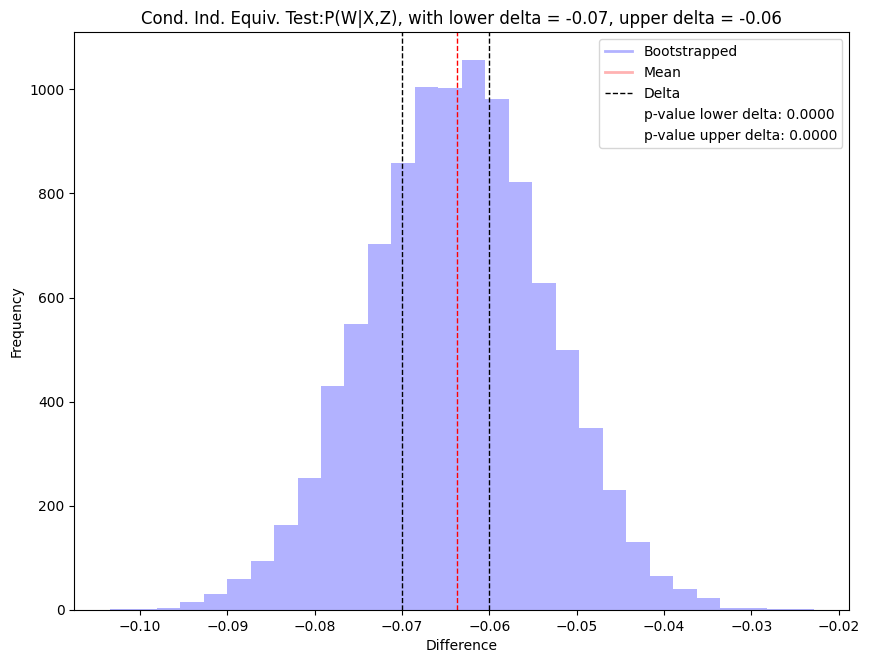

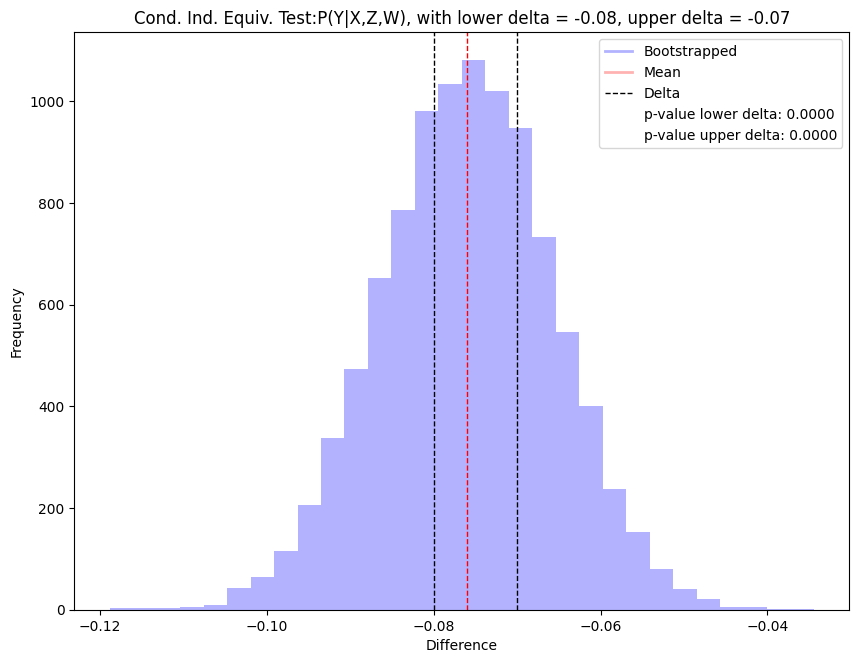

In [44]:
plt.figure(figsize=(10,7.5))
plt.hist(differences_w_fl_ny, bins=30, alpha=0.3, color='blue', label = "Bootstrapped differences")
plt.axvline(np.mean(differences_w_fl_ny), color='red', linestyle='dashed', linewidth=1, label = "Mean difference")
plt.title("Cond. Ind. Equiv. Test:P(W|X,Z), with lower delta = -0.07, upper delta = -0.06")
plt.xlabel("Difference")
plt.ylabel("Frequency")
#Add the lower and upper delta values as vertical lines
plt.axvline(-0.07, color='black', linestyle='dashed', linewidth=1, label = "Delta")
plt.axvline(-0.06, color='black', linestyle='dashed', linewidth=1, label = "Delta")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3), plt.Line2D([0], [0], color='black', linestyle='dashed', linewidth=1, label='Delta')]
plt.legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value lower delta: {p_value_lower_delta_w_fl_ny:.4f}'), plt.Line2D([0], [0], color='none', label=f'p-value upper delta: {p_value_upper_delta_w_fl_ny:.4f}')])
plt.show()

#for p(PINCP|SEX,RAC1P,SCHL)
#set plot size
plt.figure(figsize=(10,7.5))
plt.hist(differences_y_fl_ny, bins=30, alpha=0.3, color='blue', label = "Bootstrapped differences")
plt.axvline(np.mean(differences_y_fl_ny), color='red', linestyle='dashed', linewidth=1, label = "Mean difference")
plt.title("Cond. Ind. Equiv. Test:P(Y|X,Z,W), with lower delta = -0.08, upper delta = -0.07")
plt.xlabel("Difference")
plt.ylabel("Frequency")
#Add the lower and upper delta values as vertical lines
plt.axvline(-0.08, color='black', linestyle='dashed', linewidth=1, label = "Delta")
plt.axvline(-0.07, color='black', linestyle='dashed', linewidth=1, label = "Delta")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3), plt.Line2D([0], [0], color='black', linestyle='dashed', linewidth=1, label='Delta')]
plt.legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value lower delta: {p_value_lower_delta_y_fl_ny:.4f}'), plt.Line2D([0], [0], color='none', label=f'p-value upper delta: {p_value_upper_delta_y_fl_ny:.4f}')])
plt.show()

In [45]:
def indiv_equiv_bootstrap_test_schrouff(sample_a,sample_b,target, causal_parents_source,value,conditional='SEX',  B=10000, split=0.75,lower_delta = -0.01, upper_delta = 0.01):

    np.random.seed(36)
    '''
    Function to perform weighted bootstrap test for difference in conditional probabilities of Y=1 given X,Z,W for two samples
    as described in Schrouff et al. (2022)

    Parameters:

    sample_a: pandas DataFrame containing sample A
    sample_b: pandas DataFrame containing sample B
    causal_parents_source: list of strings containing causal paraents of variable of interest (i.e. PA(Y) = {X,Z,W})
    B: int, number of bootstrap iterations
    split: float, proportion of samples to use for estimating the weights using logistic regression

    Returns:

    bootstrapped_t_stats: numpy array containing bootstrapped t-statistics for each tested conditional probability
    bootstrapped_mean_probabilities: numpy array containing the mean bootstrapped probabilities for each tested conditional probability
    bootstrapped_weights_mean: numpy array containing the mean bootstrapped weights for each sample
    bootstrapped_weighted_means: numpy array containing the bootstrapped weighted means for each sample
    bootstrapped_pooled_se: numpy array containing the bootstrapped pooled standard errors for each tested conditional probability
    p_values: float containing the p-value obtained from a two-sided z-test of the bootstrapped t-statistics distribution against 0
    '''



    #Step 1: Split initial samples into weighting and testing sets
    ##Split the samples
    sample_a_weights = sample_a.sample(frac=split)
    sample_b_weights = sample_b.sample(frac=split)
    sample_a_testing = sample_a[~sample_a.index.isin(sample_a_weights.index)]
    sample_b_testing = sample_b[~sample_b.index.isin(sample_b_weights.index)]
    ##initialize empty arrays to store bootstrapped t-statistics, bootstrapped probabilities, mean bootstrapped weights and bootstrapped weighted means
    bootstrapped_t_stats = np.empty((2,B))
    differences = np.empty(B)
    #Step2: perform bootstrap
    
    if len(causal_parents_source) >0:

        for i in tqdm.tqdm(range(B), desc='Bootstrapping'):
            #Test, for each bootstrap iteration have a different set for weights and testing
            #Step 2.1: Sample with replacement from the weights and testing
            bootstrap_sample_a_weights = sample_a_weights.sample(n=len(sample_a_weights), replace=True)
            bootstrap_sample_b_weights = sample_b_weights.sample(n=len(sample_b_weights), replace=True)
            bootstrap_sample_a_testing = sample_a_testing.sample(n=len(sample_a_testing), replace=True)
            bootstrap_sample_b_testing = sample_b_testing.sample(n=len(sample_b_testing), replace=True)

            #Step 2.2: Fit logistic regression model to estimate weights
            ##Pool the samples
            pooled_weights = pd.concat([bootstrap_sample_a_weights, bootstrap_sample_b_weights])
            ##Add sample indicator
            pooled_weights['Sample'] = ['Sample A']*len(bootstrap_sample_a_weights) + ['Sample B']*len(bootstrap_sample_b_weights)
            ##Feature matrix X with intercept
            X = sm.add_constant(pooled_weights[causal_parents_source])
            ##Target vector Y with sample 1 as reference
            Y = (pooled_weights['Sample'] == 'Sample B').astype(int)
            ##Fit logistic regression model
            logit_model = sm.Logit(Y, X).fit(disp=0)
            ##extract weights on testing set
            X_a = sm.add_constant(bootstrap_sample_a_testing[causal_parents_source])
            X_b = sm.add_constant(bootstrap_sample_b_testing[causal_parents_source])
            #filter X_a by the conditional attribute (X=1)
            X_a = X_a[X_a[conditional] == value]
            X_b = X_b[X_b[conditional] == value]
            p_a = logit_model.predict(X_a)
            p_a = 1-p_a #need to compute 1-pa, because the logit model predicts the probability of being in class b
            p_b = logit_model.predict(X_b)
            #Store the mean probability for p_a
            if np.any(p_a == 0) or np.any(p_b == 0):
                print('Warning: Zero values in p_a or p_b')
            if np.any(p_a < 1e-10) or np.any(p_b < 1e-10):  # Threshold can vary based on the scale of your data
                print('Warning: Near-zero values in p_a or p_b')
            #Compute the weights
            w_a = 1/p_a
            w_b = 1/p_b
            #Normalize the weights
            w_a_norm = w_a/np.sum(w_a)
            w_b_norm = w_b/np.sum(w_b)
            #Check for nans and infs
            if np.any(np.isnan(w_a)) or np.any(np.isnan(w_b)):
                print('Warning: NaN values in w_a or w_b')
            if np.any(np.isinf(w_a)) or np.any(np.isinf(w_b)):
                print('Warning: Inf values in w_a or w_b')
            #Check for very small values
            if np.any(w_a < 1e-10) or np.any(w_b < 1e-10):
                print('Warning: Near-zero values in w_a or w_b')
            
            #Compute hadamard product
            #filter Y_a by the conditional attribute (X=1)
            relevant_a = bootstrap_sample_a_testing[bootstrap_sample_a_testing[conditional] == value]
            relevant_b = bootstrap_sample_b_testing[bootstrap_sample_b_testing[conditional] == value]
            Y_a = relevant_a[target].values
            Y_b = relevant_b[target].values
            product_a = w_a_norm.values*Y_a
            product_b = w_b_norm.values*Y_b
            sum_a = np.sum(product_a)
            sum_b = np.sum(product_b)
            difference = sum_a - sum_b
            differences[i] = difference

            '''
            together = np.concatenate([product_a,-product_b])
            bootstrapped_t_stats[0,i] = ttest_1samp(together, -delta, alternative = 'greater')[0]
            bootstrapped_t_stats[1,i] = ttest_1samp(together, delta, alternative = 'less')[0]
            '''

    else:
         for i in tqdm.tqdm(range(B), desc='Bootstrapping'):
             #sample with replacement from testing
            bootstrap_sample_a_testing = sample_a_testing.sample(n=len(sample_a_testing), replace=True)
            bootstrap_sample_b_testing = sample_b_testing.sample(n=len(sample_b_testing), replace=True)
            #Compute hadamard product
            Y_a = bootstrap_sample_a_testing[target].values
            Y_b = bootstrap_sample_b_testing[target].values
            difference = Y_a - Y_b
            differences[i] = np.mean(difference)




    #Compute t-statistic
    _, p_value_lower_delta = ttest_1samp(differences, lower_delta, alternative = 'greater')
    _, p_value_upper_delta = ttest_1samp(differences, upper_delta, alternative = 'less')
    
    '''
    #Step 3: Compute p-values
    mean_greater = np.mean(bootstrapped_t_stats[0])
    std_greater = np.std(bootstrapped_t_stats[0])
    mean_less = np.mean(bootstrapped_t_stats[1])
    std_less = np.std(bootstrapped_t_stats[1])
    p_value_greater = (2*norm.cdf(-abs((mean_greater)/std_greater)))
    p_value_less = (2*norm.cdf(-abs((mean_less)/std_less)))
    '''
    return bootstrapped_t_stats, p_value_lower_delta, p_value_upper_delta, differences

In [46]:
ny_df_sample_processed, fl_df_sample_processed 

#perform the indivual test for florida and new york 
'''
#race|sex
target = 'RAC1P'
causal_parents_source = 'SEX'
conditional = 'SEX'
value = 1
#_, p_value_lower_delta_z_x1_fl_ny, p_value_upper_delta_z_x1_fl_ny, differences_z_x1_fl_ny = indiv_equiv_bootstrap_test_schrouff(fl_df_sample_processed, ny_df_sample_processed, target, causal_parents_source,value,split = 0.5, lower_delta = 0.07, upper_delta = 0.8,B=1000)
#now for value 0    
value = 0
_, p_value_lower_delta_z_x0_fl_ny, p_value_upper_delta_z_x0_fl_ny, differences_z_x0_fl_ny = indiv_equiv_bootstrap_test_schrouff(fl_df_sample_processed, ny_df_sample_processed, target, causal_parents_source,value,split = 0.5, lower_delta = 0.09, upper_delta = 0.11,B=1000)

#school|race,sex
target = 'SCHL'
causal_parents_source = ['RAC1P','SEX']
conditional = 'SEX'
value = 1

#_, p_value_lower_delta_w_x1_fl_ny, p_value_upper_delta_w_x1_fl_ny, differences_w_x1_fl_ny = indiv_equiv_bootstrap_test_schrouff(fl_df_sample_processed, ny_df_sample_processed, target, causal_parents_source,value,B=1000,split = 0.5, lower_delta = -0.07, upper_delta = -0.06)
value = 0

#_, p_value_lower_delta_w_x0_fl_ny, p_value_upper_delta_w_x0_fl_ny, differences_w_x0_fl_ny = indiv_equiv_bootstrap_test_schrouff(fl_df_sample_processed, ny_df_sample_processed, target, causal_parents_source,value,B=1000,split = 0.5, lower_delta = -0.07, upper_delta = -0.06)
conditional = 'RAC1P'

value = 1
#_, p_value_lower_delta_w_z1_fl_ny, p_value_upper_delta_w_z1_fl_ny, differences_w1_fl_ny = indiv_equiv_bootstrap_test_schrouff(fl_df_sample_processed, ny_df_sample_processed, target, causal_parents_source,value,B=1000,split = 0.5, lower_delta = -0.07, upper_delta = -0.06)
value = 0
_, p_value_lower_delta_w_z0_fl_ny, p_value_upper_delta_w_z0_fl_ny, differences_w0_fl_ny = indiv_equiv_bootstrap_test_schrouff(fl_df_sample_processed, ny_df_sample_processed, target, causal_parents_source,value,B=1000,split = 0.5, lower_delta = -0.07, upper_delta = -0.06)
'''

#income|school,race,sex
target = 'PINCP'
fl_male_white = fl_df_sample_processed[(fl_df_sample_processed['SEX']==1) & (fl_df_sample_processed['RAC1P']==1)]
ny_male_white = ny_df_sample_processed[(ny_df_sample_processed['SEX']==1) & (ny_df_sample_processed['RAC1P']==1)]
fl_male_non_white = fl_df_sample_processed[(fl_df_sample_processed['SEX']==1) & (fl_df_sample_processed['RAC1P']==0)]
ny_male_non_white = ny_df_sample_processed[(ny_df_sample_processed['SEX']==1) & (ny_df_sample_processed['RAC1P']==0)]
fl_female_white = fl_df_sample_processed[(fl_df_sample_processed['SEX']==0) & (fl_df_sample_processed['RAC1P']==1)]
ny_female_white = ny_df_sample_processed[(ny_df_sample_processed['SEX']==0) & (ny_df_sample_processed['RAC1P']==1)]
fl_female_non_white = fl_df_sample_processed[(fl_df_sample_processed['SEX']==0) & (fl_df_sample_processed['RAC1P']==0)]
ny_female_non_white = ny_df_sample_processed[(ny_df_sample_processed['SEX']==0) & (ny_df_sample_processed['RAC1P']==0)]
causal_parents_source = []
##testing
_, p_value_lower_delta_y_x1z1w_fl_ny, p_value_upper_delta_y_x1z1w_fl_ny, differences_y_x1z1w_fl_ny = equiv_bootstrap_test_schrouff(fl_male_white,ny_male_white,target,causal_parents_source,B=1000,split = 0.5, lower_delta = -0.12, upper_delta = -0.11)
_, p_value_lower_delta_y_x1z0w_fl_ny, p_value_upper_delta_y_x1z0w_fl_ny, differences_y_x1z0w_fl_ny = equiv_bootstrap_test_schrouff(fl_male_non_white,ny_male_non_white,target,causal_parents_source,B=1000,split = 0.5, lower_delta = -0.06, upper_delta = -0.05)
_, p_value_lower_delta_y_x0z1w_fl_ny, p_value_upper_delta_y_x0z1w_fl_ny, differences_y_x0z1w_fl_ny = equiv_bootstrap_test_schrouff(fl_female_white,ny_female_white,target,causal_parents_source,B=1000,split = 0.5, lower_delta = -0.11, upper_delta = -0.09)
_, p_value_lower_delta_y_x0z0w_fl_ny, p_value_upper_delta_y_x0z0w_fl_ny, differences_y_x0z0w_fl_ny = equiv_bootstrap_test_schrouff(fl_female_non_white,ny_female_non_white,target,causal_parents_source,B=1000,split = 0.5, lower_delta = -0.17, upper_delta = -0.16)





Bootstrapping: 100%|██████████| 1000/1000 [00:00<00:00, 1891.68it/s]


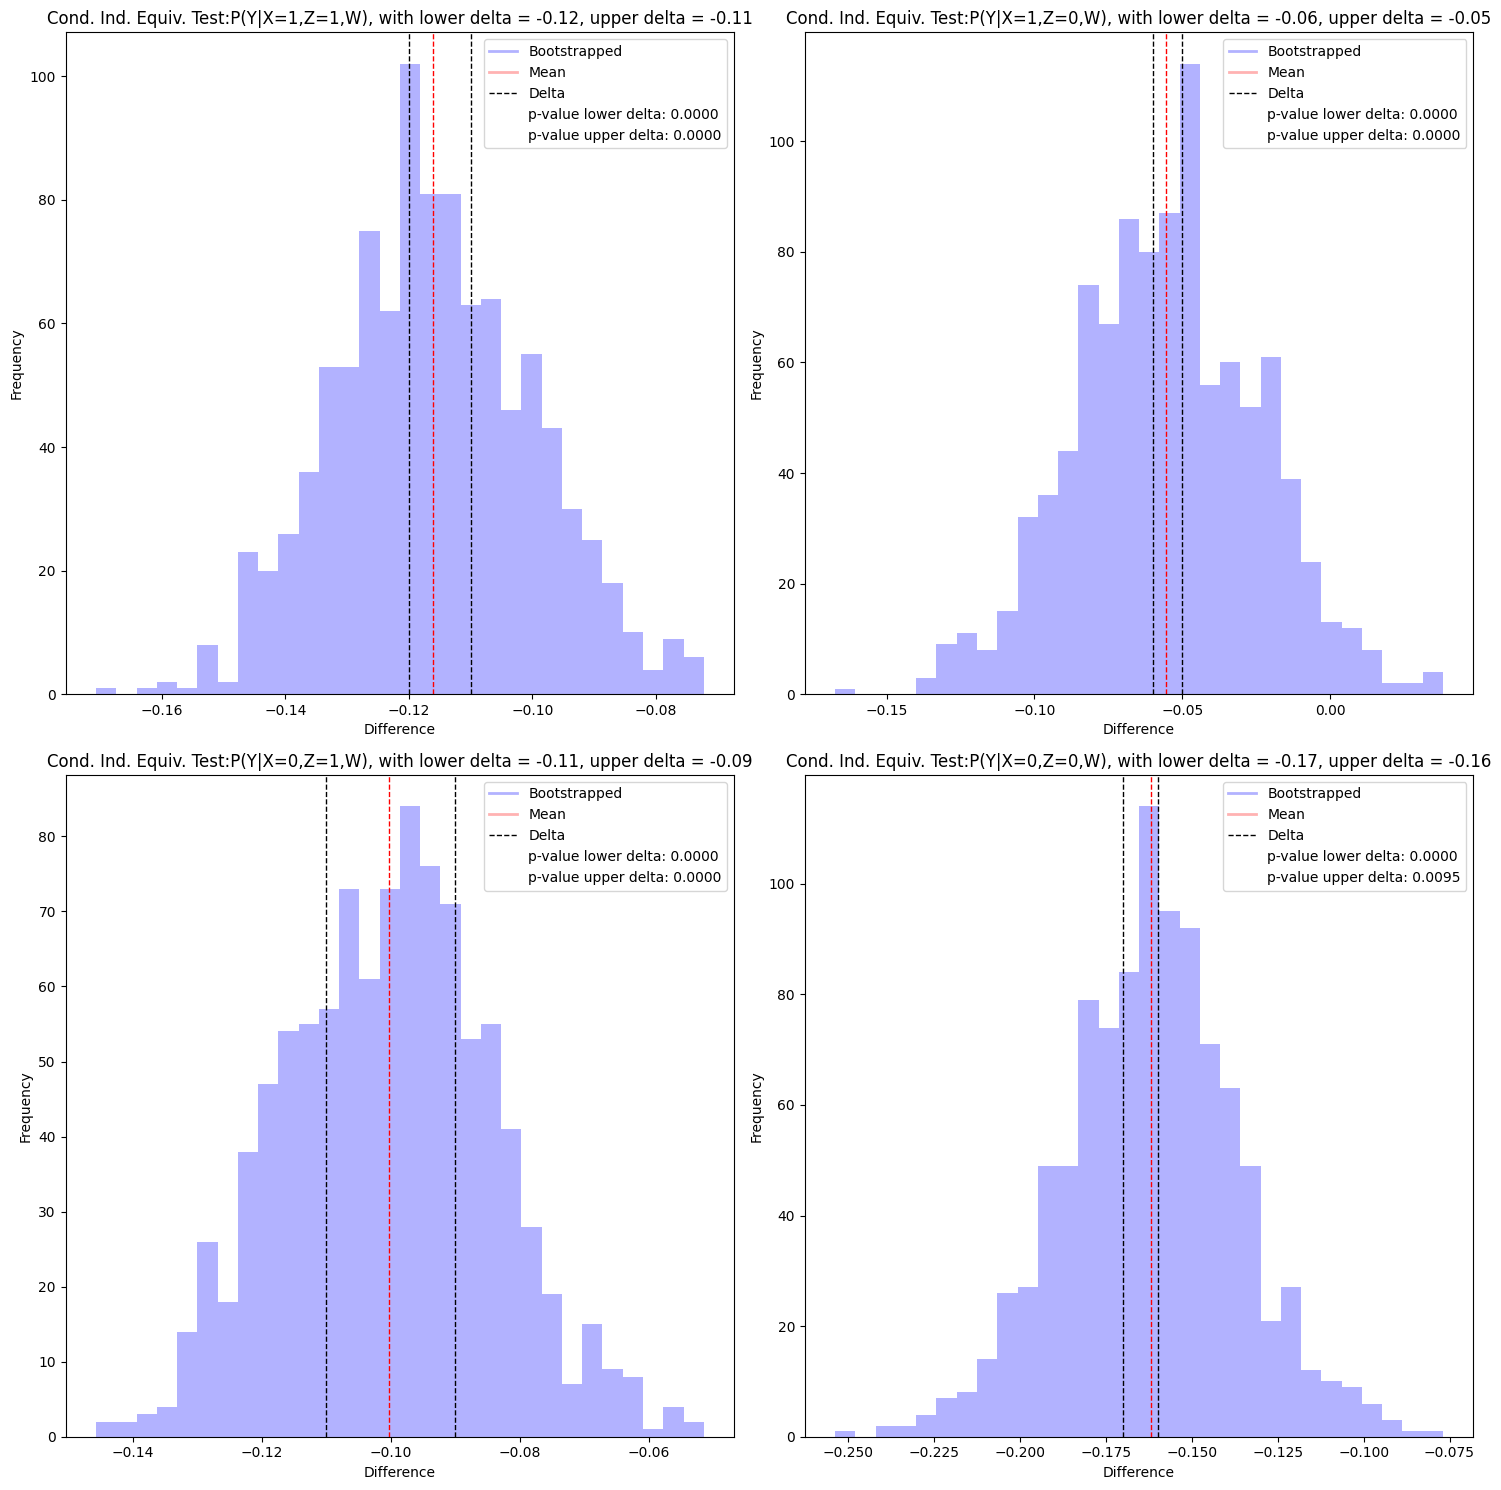

In [53]:
#Histogram for the differences in conditional probabilities
fig, axs = plt.subplots(2,2,figsize=(15,15))
axs[0,0].hist(differences_y_x1z1w_fl_ny, bins=30, alpha=0.3, color='blue', label = "Bootstrapped differences")
axs[0,0].axvline(np.mean(differences_y_x1z1w_fl_ny), color='red', linestyle='dashed', linewidth=1, label = "Mean difference")
axs[0,0].set_title("Cond. Ind. Equiv. Test:P(Y|X=1,Z=1,W), with lower delta = -0.12, upper delta = -0.11")
axs[0,0].set_xlabel("Difference")
axs[0,0].set_ylabel("Frequency")
#Add the lower and upper delta values as vertical lines
axs[0,0].axvline(-0.12, color='black', linestyle='dashed', linewidth=1, label = "Delta")
axs[0,0].axvline(-0.11, color='black', linestyle='dashed', linewidth=1, label = "Delta")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3), plt.Line2D([0], [0], color='black', linestyle='dashed', linewidth=1, label='Delta')]
axs[0,0].legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value lower delta: {p_value_lower_delta_y_x1z1w_fl_ny:.4f}'), plt.Line2D([0], [0], color='none', label=f'p-value upper delta: {p_value_upper_delta_y_x1z1w_fl_ny:.4f}')])

axs[0,1].hist(differences_y_x1z0w_fl_ny, bins=30, alpha=0.3, color='blue', label = "Bootstrapped differences")
axs[0,1].axvline(np.mean(differences_y_x1z0w_fl_ny), color='red', linestyle='dashed', linewidth=1, label = "Mean difference")
axs[0,1].set_title("Cond. Ind. Equiv. Test:P(Y|X=1,Z=0,W), with lower delta = -0.06, upper delta = -0.05")
axs[0,1].set_xlabel("Difference")
axs[0,1].set_ylabel("Frequency")
#Add the lower and upper delta values as vertical lines
axs[0,1].axvline(-0.06, color='black', linestyle='dashed', linewidth=1, label = "Delta")
axs[0,1].axvline(-0.05, color='black', linestyle='dashed', linewidth=1, label = "Delta")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3), plt.Line2D([0], [0], color='black', linestyle='dashed', linewidth=1, label='Delta')]

axs[0,1].legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value lower delta: {p_value_lower_delta_y_x1z0w_fl_ny:.4f}'), plt.Line2D([0], [0], color='none', label=f'p-value upper delta: {p_value_upper_delta_y_x1z0w_fl_ny:.4f}')])

axs[1,0].hist(differences_y_x0z1w_fl_ny, bins=30, alpha=0.3, color='blue', label = "Bootstrapped differences")
axs[1,0].axvline(np.mean(differences_y_x0z1w_fl_ny), color='red', linestyle='dashed', linewidth=1, label = "Mean difference")
axs[1,0].set_title("Cond. Ind. Equiv. Test:P(Y|X=0,Z=1,W), with lower delta = -0.11, upper delta = -0.09")
axs[1,0].set_xlabel("Difference")
axs[1,0].set_ylabel("Frequency")
#Add the lower and upper delta values as vertical lines
axs[1,0].axvline(-0.11, color='black', linestyle='dashed', linewidth=1, label = "Delta")
axs[1,0].axvline(-0.09, color='black', linestyle='dashed', linewidth=1, label = "Delta")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3), plt.Line2D([0], [0], color='black', linestyle='dashed', linewidth=1, label='Delta')]
axs[1,0].legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value lower delta: {p_value_lower_delta_y_x0z1w_fl_ny:.4f}'), plt.Line2D([0], [0], color='none', label=f'p-value upper delta: {p_value_upper_delta_y_x0z1w_fl_ny:.4f}')])

axs[1,1].hist(differences_y_x0z0w_fl_ny, bins=30, alpha=0.3, color='blue', label = "Bootstrapped differences")
axs[1,1].axvline(np.mean(differences_y_x0z0w_fl_ny), color='red', linestyle='dashed', linewidth=1, label = "Mean difference")
axs[1,1].set_title("Cond. Ind. Equiv. Test:P(Y|X=0,Z=0,W), with lower delta = -0.17, upper delta = -0.16")
axs[1,1].set_xlabel("Difference")
axs[1,1].set_ylabel("Frequency")
#Add the lower and upper delta values as vertical lines
axs[1,1].axvline(-0.17, color='black', linestyle='dashed', linewidth=1, label = "Delta")
axs[1,1].axvline(-0.16, color='black', linestyle='dashed', linewidth=1, label = "Delta")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3), plt.Line2D([0], [0], color='black', linestyle='dashed', linewidth=1, label='Delta')]
axs[1,1].legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value lower delta: {p_value_lower_delta_y_x0z0w_fl_ny:.4f}'), plt.Line2D([0], [0], color='none', label=f'p-value upper delta: {p_value_upper_delta_y_x0z0w_fl_ny:.4f}')])

plt.tight_layout()
plt.show()


In [49]:
differences_y_x1z1w_fl_ny.shape[0]

1000

In [ ]:
#perform the indivual test for florida and utah 

#race|sex
target = 'RAC1P'
causal_parents_source = 'SEX'
conditional = 'SEX'
value = 1
#_, p_value_lower_delta_z_x1_fl_ut, p_value_upper_delta_z_x1_fl_ut, differences_z_x1_fl_ut = indiv_equiv_bootstrap_test_schrouff(fl_df_sample_processed, ut_df_sample_processed, target, causal_parents_source,value,split = 0.5, lower_delta = -0.09, upper_delta = -0.08,B=1000)
#now for value 0    
value = 0
#_, p_value_lower_delta_z_x0_fl_ut, p_value_upper_delta_z_x0_fl_ut, differences_z_x0_fl_ut = indiv_equiv_bootstrap_test_schrouff(fl_df_sample_processed, ut_df_sample_processed, target, causal_parents_source,value,split = 0.5, lower_delta = -0.11, upper_delta = -0.10,B=1000)

#school|race,sex
target = 'SCHL'
causal_parents_source = ['RAC1P','SEX']
conditional = 'SEX'
value = 1

#_, p_value_lower_delta_w_x1_fl_ut, p_value_upper_delta_w_x1_fl_ut, differences_w_x1_fl_ut = indiv_equiv_bootstrap_test_schrouff(fl_df_sample_processed, ut_df_sample_processed, target, causal_parents_source,value,B=1000,split = 0.5, lower_delta = 0.01, upper_delta = 0.02)
value = 0

_, p_value_lower_delta_w_x0_fl_ut, p_value_upper_delta_w_x0_fl_ut, differences_w_x0_fl_ut = indiv_equiv_bootstrap_test_schrouff(fl_df_sample_processed, ut_df_sample_processed, target, causal_parents_source,value,B=1000,split = 0.5,lower_delta = 0.01, upper_delta = 0.02)
conditional = 'RAC1P'

value = 1
#_, p_value_lower_delta_w_z1_fl_ut, p_value_upper_delta_w_z1_fl_ut, differences_w1_fl_ut = indiv_equiv_bootstrap_test_schrouff(fl_df_sample_processed, ny_df_sample_processed, target, causal_parents_source,value,B=1000,split = 0.5, lower_delta = -0.07, upper_delta = -0.06)
value = 0
#_, p_value_lower_delta_w_z0_fl_ny, p_value_upper_delta_w_z0_fl_ny, differences_w0_fl_ny = indiv_equiv_bootstrap_test_schrouff(fl_df_sample_processed, ny_df_sample_processed, target, causal_parents_source,value,B=1000,split = 0.5, lower_delta = -0.07, upper_delta = -0.06)


In [ ]:
p_value_lower_delta_w_x0_fl_ut, p_value_upper_delta_w_x0_fl_ut